In [3]:
import os
import struct
import datetime
# from skfda import FDataGrid
# from skfda.preprocessing.dim_reduction import FPCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import gaussian_filter1d
import torch.nn as nn
import splitfolders
from tensorflow.keras.models import load_model
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import torch
from PIL import Image
from torchvision.transforms import ToTensor
import random
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Sandbox

In [4]:
class Ratio_LRNN_v2(nn.Module):
    def __init__(self, hidden_layer=5):
        super(Ratio_LRNN_v2, self).__init__()
        # self.lin = nn.Linear(1, 1)

        self.input_size = 5 # x1, x2, x3, x4 (2 dimensions w one-hot encoding in forward) WITHOUT INTERACTIONS

        self.layers = nn.Sequential(
            nn.BatchNorm1d(self.input_size),
            nn.Linear(self.input_size, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, 1)

        )
        
    def forward(self, x1, x2, x3, x4):
        x4_encoded = torch.zeros(x4.size(0),2)
        x4_encoded[x4=='v1',0] = 1
        x4_encoded[x4=='v2',1] = 1

        X = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x4_encoded], dim=1)

        return self.layers(X)

In [5]:
class Ratio_LRNN(nn.Module):
    def __init__(self, hidden_layer=5):
        super(Ratio_LRNN, self).__init__()
        # self.lin = nn.Linear(1, 1)

        self.input_size = 5 # x1, x2, x3, x4 (2 dimensions w one-hot encoding in forward) WITHOUT INTERACTIONS

        self.layers = nn.Sequential(
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(self.input_size, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, 1)

        )
        
    def forward(self, x1, x2, x3, x4):
        x4_encoded = torch.zeros(x4.size(0),2)
        x4_encoded[x4=='v1',0] = 1
        x4_encoded[x4=='v2',1] = 1

        X = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x4_encoded], dim=1)

        return self.layers(X)

In [6]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

class BayesianProfile_v2:
    def __init__(self, prior_mean_y1=None, prior_mean_y2=None, prior_cov_y1=None, prior_cov_y2=None, x4_categories=['v1', 'v2']):
        """
        Initialize a Bayesian profile for a subject
        
        Parameters:
        prior_mean: Initial guess for parameters (default: zeros)
        prior_cov: Initial uncertainty in parameters (default: identity matrix)
        """
        # For 3 parameters: β₀ (intercept), β₁ (x1), β₂ (x2),  β3 (x3), β4 (x1*x2), B5 (x1*x3), B6 (x2*x3), B7 (x1*x2*x3) NOW ADDING IN X4 AS VX
        # Will need experimentation to understand the predictive power of interactive terms
        self.n_params = 24
        
        # Initialize priors
        if prior_mean_y1 is None:
            self.mean_y1 = np.zeros(self.n_params)
        else:
            self.mean = prior_mean_y1

        if prior_mean_y2 is None:
            self.mean_y2 = np.zeros(self.n_params)
        else:
            self.mean = prior_mean_y2
            
        if prior_cov_y1 is None:
            self.cov_y1 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y1 = prior_cov_y1

        if prior_cov_y2 is None:
            self.cov_y2 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y2 = prior_cov_y2
        
        self.x4_categories = x4_categories

        # Keep track of all data points
        self.X_history = []
        self.y1_history = []
        self.y2_history = []
        
        # For tracking prediction performance
        self.rmse_history_y1 = []
        self.rmse_history_y2 = []


    def encode_x4(self, x4):
        """
        Encode categorical x4 value using one-hot encoding
        """
        if isinstance(x4, pd.Series):
            x4 = x4.iloc[0]  # Take first value if it's a series
        
        # Create one-hot encoding
        encoding = np.zeros(len(self.x4_categories))
        if x4 in self.x4_categories:
            encoding[self.x4_categories.index(x4)] = 1
        return encoding
        
    def add_observation_y1(self, x1, x2, x3, x4, y1, noise_var=1.0):
        """
        Update the profile with a new observation
        
        Parameters:
        x1, x2: Input features
        y: Observed outcome
        noise_var: Assumed variance in measurements
        """
        # Create feature vector including interaction
        # print(f"x4 BEFORE passed to encoder function: {x4}")
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        y1_value = float(y1)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y1_history.append(y1_value)
        
        # Compute Kalman gain
        K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var)

        innovation = y1_value -float(X @ self.mean_y1)
        self.mean_y1 = self.mean_y1 + (K.flatten() * innovation)
        self.cov_y1 = self.cov_y1 - (K @ X @ self.cov_y1)

        # Update RMSE
        y1_pred = self.predict_y1(x1[0,0], x2[0,0], x3[0,0], x4)
        rmse = np.sqrt(np.mean((np.array(self.y1_history) - 
                               [self.predict_y1(x[1], x[2], x[3], x[4]) for x in self.X_history])**2))
        self.rmse_history_y1.append(rmse)

    def add_observation_y2(self, x1, x2, x3, x4, y2, noise_var=1.0):
        """
        Update the profile with a new observation
        
        Parameters:
        x1, x2: Input features
        y: Observed outcome
        noise_var: Assumed variance in measurements
        """
        # Create feature vector including interaction
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        y2_value = float(y2)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y2_history.append(y2_value)
        
        # Kalman gain
        K = self.cov_y2 @ X.T @ np.linalg.inv(X @ self.cov_y2 @ X.T + noise_var)

        innovation = y2_value -float(X @ self.mean_y2)
        self.mean_y2 = self.mean_y2 + (K.flatten() * innovation)
        self.cov_y2 = self.cov_y2 - (K @ X @ self.cov_y2)
        
        # Update RMSE
        y2_pred = self.predict_y2(x1, x2, x3, x4)
        rmse = np.sqrt(np.mean((np.array(self.y2_history) - 
                               [self.predict_y2(x[1], x[2], x[3], x[4]) for x in self.X_history])**2))
        self.rmse_history_y2.append(rmse)
    
    def predict_y1(self, x1, x2, x3, x4):
        """
        Make a prediction for given input values
        
        Parameters:
        x1, x2: Input features
        
        Returns:
        float: Predicted value
        """
        # x1 = np.asarray(x1).reshape(-1)
        # x2 = np.asarray(x2).reshape(-1)
        # x3 = np.asarray(x3).reshape(-1)
        # x4_encoded = self.encode_x4(x4)
        
        # # Make sure all inputs have the same first dimension
        # n = max(x1.size, x2.size, x3.size)
        # if x1.size == 1:
        #     x1 = np.repeat(x1, n)
        # if x2.size == 1:
        #     x2 = np.repeat(x2, n)
        # if x3.size == 1:
        #     x3 = np.repeat(x3, n)

        # X = np.column_stack((
        #     np.ones_like(x1), x1, x2, x3, x4_encoded,
        #     x1*x2, x1*x3, np.outer(x1, x4_encoded).reshape(x1.size, -1), 
        #     x2*x3, np.outer(x2, x4_encoded).reshape(x2.size, -1), 
        #     np.outer(x3, x4_encoded).reshape(x3.size, -1),
        #     x1*x2*x3, 
        #     np.outer(x1*x2, x4_encoded).reshape((x1*x2).size, -1),
        #     np.outer(x1*x3, x4_encoded).reshape((x1*x3).size, -1),
        #     np.outer(x2*x3, x4_encoded).reshape((x2*x3).size, -1),
        #     np.outer(x1*x2*x3, x4_encoded).reshape((x1*x2*x3).size, -1)
        # ))
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)
        
        return X @ self.mean_y1
    
    def predict_y2(self, x1, x2, x3, x4):
        """
        Make a prediction for given input values
        
        Parameters:
        x1, x2: Input features
        
        Returns:
        float: Predicted value
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)

        return X @ self.mean_y2
    
    def predict_with_uncertainty_y1(self, x1, x2, x3, x4):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        pred = X @ self.mean_y1
        std = np.sqrt(X @ self.cov_y1 @ X.T)
        return float(pred), float(std)
    
    def predict_with_uncertainty_y2(self, x1, x2, x3, x4):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        pred = X @ self.mean_y2
        std = np.sqrt(X @ self.cov_y2 @ X.T)
        return float(pred), float(std)
    
    def plot_learning_curve_y1(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y1, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - Average Synapses to IHC Prediction')
        return plt.gcf()
    
    def plot_learning_curve_y2(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y2, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - IHCs Prediction')
        return plt.gcf()
    
def plot_multiple_learning_curves(profiles, profile_names=None, metric='y1', figsize=(12, 7)):
    """
    Plot RMSE learning curves for multiple Bayesian profiles
    
    Parameters:
    profiles (list): List of BayesianProfile_v2 objects
    profile_names (list): Optional list of names for each profile
    metric (str): Either 'y1' or 'y2' to specify which metric to plot
    figsize (tuple): Figure size
    
    Returns:
    matplotlib.figure.Figure: The generated plot
    """
    plt.figure(figsize=figsize)
    
    # Generate colors using a colormap
    colors = plt.cm.tab10(np.linspace(0, 1, len(profiles)))
    
    # If no profile names provided, create default ones
    if profile_names is None:
        profile_names = [f'Profile {i+1}' for i in range(len(profiles))]
    
    # Plot each profile's learning curve
    for profile, name, color in zip(profiles, profile_names, colors):
        if metric == 'y1':
            rmse_history = profile.rmse_history_y1
            title = 'Learning Curves - Average Synapses to IHC Prediction'
        else:
            rmse_history = profile.rmse_history_y2
            title = 'Learning Curves - IHCs Prediction'
            
        plt.plot(rmse_history, '-o', color=color, label=name, alpha=0.8, 
                markersize=4, linewidth=2)
    
    plt.xlabel('Number of Observations')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

In [7]:
from torch.optim import Adam


class MultiModalValueToImageFeaturePredict(nn.Module):
    def __init__(self, numerical_input_size=3, img_input_size=64):
        self.numerical_input_size = numerical_input_size
        self.img_input_size = img_input_size
        """
        Autoencoder to map specific input values to images.

        Args:
            input_size (int): Number of specific values to be used as input.
            img_size (int): Size of one side of the square image (e.g., for 28x28, img_size=28).
        """
        super(MultiModalValueToImageFeaturePredict, self).__init__()
        self.numerical_encoder = nn.Sequential(
            nn.Linear(numerical_input_size, 128), # 128 is a somewhat middle ground, can adjust
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        # self.img_encoder = nn.Sequential(
        #     nn.Linear(img_input_size ** 2 , 128),  # Flatten image into vector if it's input
        #     nn.ReLU(),
        #     nn.Linear(128, 64),
        #     nn.ReLU()
        # )
        self.feature_predictor = nn.Sequential(
            nn.Linear(128, 64),  # Adjust the final layer to match combined latent size
            nn.ReLU(),
            nn.Linear(64, 1)  # Assuming a single output feature, adjust as necessary
        )

    def forward(self, numerical_input, image_input):
        """
        Forward pass: Transforms input values into latent representation and predicts image features.

        Args:
            numerical_input (torch.Tensor): Numerical inputs of shape (batch_size, numerical_input_size).
            image_input (torch.Tensor): Image inputs of shape (batch_size, img_size, img_size).

        Returns:
            torch.Tensor: Predicted features of shape (batch_size, feature_output_size).
        """
        numerical_latent = self.numerical_encoder(numerical_input)
        # image_latent = self.img_encoder(image_input.view(-1, self.img_size ** 2))  # Flatten image
        # combined_latent = torch.cat([numerical_latent, image_latent], dim=1)
        # predicted_features = self.feature_predictor(combined_latent)
        predicted_features = self.feature_predictor(numerical_latent)
        return predicted_features
    

    def fit(self, dataloader, epochs=10, lr=1e-3, device='cpu'):
            """
            Train the model using the provided dataloader.

            Args:
                dataloader (DataLoader): PyTorch DataLoader providing paired inputs (numerical, images, features).
                epochs (int): Number of training epochs.
                lr (float): Learning rate for optimizer.
                device (str): Device to train on ('cpu' or 'cuda').
            """
            self.to(device)
            optimizer = Adam(self.parameters(), lr=lr)
            criterion = nn.MSELoss()  # Loss for regression tasks

            for epoch in range(epochs):
                epoch_loss = 0
                self.train()
                for result in results:
                    file,thresh, target = result
                    
                    # Convert threshold and target to appropriate types if necessary
                    # thresh = float(thresh)  # Ensure threshold is a float
                    # target = int(target)    # Ensure target is an integer
                    # image_data = next((item for item in train_ds if item[0] == file), None)

                    # if image_data is None:
                    #     raise ValueError(f"Image file '{file}' not found in the dataset.")

                    # image_input = image_data[1]  # Assuming image_data is (filename, image_tensor)

                    # Load the data and process as before
                    # image_input = load_image_data(file)
                    image_input = torch.zeros(1, self.img_input_size * self.img_input_size).to(device)
                    thresh = torch.tensor([thresh], dtype=torch.float32)  # Create tensor from threshold

                    # Move to device
                    numerical_input = thresh.view(-1,1)
                    # image_input = image_input.to(device)

                    # Forward pass
                    # predicted_features = self(numerical_input, image_input)
                    predicted_features = self(numerical_input)

                    # Compute loss
                    target_features = torch.tensor([target], dtype=torch.float32).to(device)
                    loss = criterion(predicted_features, target_features)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()

                print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(results):.4f}")

In [8]:
def peaks_and_troughs_v2(df, freq, db, time_scale=10):
    khz = df[(df['Freq(Hz)'] == freq) & (df['Level(dB)'] == db)]
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()

        target = int(244 * (time_scale / 10))
        
        y_values = interpolate_and_smooth(final, target)  # Original y-values for plotting
        sampling_rate = len(y_values) / time_scale  # Assuming 10 ms duration for 244 points

        # x_values = np.linspace(0, len(y_values) / sampling_rate, len(y_values))
        y_values_for_peak_finding = interpolate_and_smooth(final[:244])

        highest_peaks, relevant_troughs = peak_finding(y_values_for_peak_finding)

        return highest_peaks, relevant_troughs
    return None, None, None, None

In [9]:
def calc_amplitude(df, freq, db, time_scale=10):
    khz = df[(df['Freq(Hz)'] == freq) & (df['Level(dB)'] == db)]
    # khz = df[(np.isclose(df['Freq(Hz)'], freq)) & (np.isclose(df['Level(dB)'], db))]
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()
        # wave = interpolate_and_smooth(final) this isi already in peak_finding
        highest_smoothed_peaks, relevant_troughs = peak_finding(final)
        if highest_smoothed_peaks.size > 0:  # Check if highest_peaks is not empty
            first_peak_amplitude = final[highest_smoothed_peaks[0]] - final[relevant_troughs[0]]
        return first_peak_amplitude

In [10]:
def peaks_and_troughs_v3(df, freq, db, time_scale=40):
    khz = df[(df['Freq(Hz)'] == freq) & (df['Level(dB)'] == db)]
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':'256'].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()

        target = int(244 * (time_scale / 10))
        
        y_values = interpolate_and_smooth(final, target)  # Original y-values for plotting
        sampling_rate = len(y_values) / time_scale  # Assuming 10 ms duration for 244 points

        x_values = np.linspace(0, len(y_values) / sampling_rate, len(y_values))
        y_values_for_peak_finding = interpolate_and_smooth(final[:244])

        highest_peaks, relevant_troughs = peak_finding(y_values_for_peak_finding)

        if highest_peaks.size > 0:  # Check if highest_peaks is not empty
            first_peak_amplitude = y_values[highest_peaks[0]] - y_values[relevant_troughs[0]]

        return highest_peaks, relevant_troughs
    return None, None, None, None

In [11]:
def calc_amplitude_v2(df, freq, db, time_scale=10):
    khz = df[(df['Freq(Hz)'] == freq) & (df['Level(dB)'] == db)]
    # khz = df[(np.isclose(df['Freq(Hz)'], freq)) & (np.isclose(df['Level(dB)'], db))]
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()
        # wave = interpolate_and_smooth(final) this isi already in peak_finding
        highest_smoothed_peaks, relevant_troughs = peaks_and_troughs_v2(final, freq = freq, db=db)
        if highest_smoothed_peaks.size > 0:  # Check if highest_peaks is not empty
            first_peak_amplitude = final[highest_smoothed_peaks[0]] - final[relevant_troughs[0]]
        return first_peak_amplitude

In [12]:
def peaks_troughs_amp(df, freq, db, time_scale=10):
    khz = df[(df['Freq(Hz)'] == freq) & (df['Level(dB)'] == db)]
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':'256'].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()

        target = int(244 * (time_scale / 10))
        
        y_values = interpolate_and_smooth(final, target)  # Original y-values for plotting
        sampling_rate = len(y_values) / time_scale  # Assuming 10 ms duration for 244 points

        x_values = np.linspace(0, len(y_values) / sampling_rate, len(y_values))
        y_values_for_peak_finding = interpolate_and_smooth(final[:244])

        highest_peaks, relevant_troughs = peak_finding(y_values_for_peak_finding)

        if highest_peaks.size > 0:  # Check if highest_peaks is not empty
            first_peak_amplitude = y_values[highest_peaks[0]] - y_values[relevant_troughs[0]]

        return highest_peaks, relevant_troughs, first_peak_amplitude
    
    return None, None, None, None

In [13]:
def peaks_and_troughs(df, freq, db):
    
    khz = df[(df['Freq(Hz)'] == freq) & (df['Level(dB)'] == db)]
    # khz = df[(np.isclose(df['Freq(Hz)'], freq, atol=1e-3)) & (np.isclose(df['Level(dB)'], db, atol=1e-3))]
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()
        print(final)
        # wave = interpolate_and_smooth(final) this isi already in peak_finding
        highest_smoothed_peaks, relevant_troughs = peak_finding(final)
        return highest_smoothed_peaks, relevant_troughs

In [14]:
# Attempting to pair data for multimodal input

ints = tuple([str(x) for x in range(1,10)])
base_image_directory = '/Users/leahashebir/Downloads/Manor_Practicum/manor_lauren/image_data'

all_images = []
for dir in os.listdir(base_image_directory):
    print(dir)
    for file in os.listdir(os.path.join(base_image_directory,dir)):
        if file.startswith(ints):
            path = os.path.join(base_image_directory,dir,file)
            img = Image.open(path)
            img_array = np.array(img)
            img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
            new_file = (file,img_tensor)
            all_images.append(new_file)

all_images

1295_projections
1293_projections
1296_projections
1294_projections
1302_projections
1301_projections
1304_projections


[('1295L_airyscan_SR-4Y_myo405_nf488_CtBP561_vGlut647_8kHzB_BasalT-B-01_processed.tif',
  <tf.Tensor: shape=(2232, 2232), dtype=float32, numpy=
  array([[ 1.,  1.,  1., ...,  5.,  5.,  5.],
         [ 1.,  1.,  1., ...,  5.,  5.,  5.],
         [ 1.,  1.,  1., ...,  6.,  6.,  5.],
         ...,
         [ 2.,  1.,  1., ..., 10., 10.,  8.],
         [ 2.,  2.,  1., ..., 10., 10.,  9.],
         [ 2.,  2.,  1., ..., 10.,  9.,  8.]], dtype=float32)>),
 ('1295L_airyscan_SR-4Y_myo405_nf488_CtBP561_vGlut647_8kHzA_BasalT-B-01-Airyscan Processing-01.tif',
  <tf.Tensor: shape=(2232, 2232), dtype=float32, numpy=
  array([[0., 0., 0., ..., 2., 2., 2.],
         [0., 0., 0., ..., 2., 2., 2.],
         [0., 0., 0., ..., 3., 2., 2.],
         ...,
         [0., 0., 0., ..., 3., 3., 2.],
         [0., 0., 0., ..., 3., 3., 2.],
         [0., 0., 0., ..., 2., 3., 2.]], dtype=float32)>),
 ('1293L_airyscan_SR-4Y_myo405_nf488_CtBP561_vGlut647_32kHzBasalR-L-01_processed.tif',
  <tf.Tensor: shape=(2232, 223

In [15]:
# abr_test = "/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/ABR-104-L-11.3.tsv"
# raw_data =  pd.read_csv(abr_test, sep="\t", encoding="ISO-8859-1") 
# filtered_data = raw_data.applymap(lambda x: pd.to_numeric(x, errors='coerce')).dropna()
# filtered_data.head()
# # > 1:
# #     data = pd.read_csv(abr_test, sep='\t', encoding='ISO-8859-1')
# # else:
# #     data = pd.read_csv(abr_test, sep='\t', skiprows=2, encoding='ISO-8859-1')

# # freqs = data['Freq(Hz)'].unique().tolist()
# # # print(freqs)
# # levels = data['Level(dB)'].unique().tolist()
# # # print(levels)
# # for freq in freqs:
# #     for lvl in levels:
# #         highs, lows = peaks_and_troughs(df=data, freq=freq, db=lvl)

In [16]:
# import pandas as pd
# import io

# def read_custom_tsv(file_path, META = False):
#     # Read the entire file
#     with open(file_path, 'r', encoding='ISO-8859-1') as f:
#         content = f.read()
    
#     # Split the content into metadata and data sections
#     metadata_lines = []
#     data_section = None
    
#     # Find the ':DATA' marker
#     data_start = content.find(':DATA')
    
#     if data_start != -1:
#         # Extract metadata (lines before ':DATA')
#         metadata_lines = content[:data_start].split('\n')
        
#         # Extract data section
#         data_section = content[data_start:].split(':DATA')[1].strip()
    
#     # Print metadata for context
#     if META == True:
#         print("Metadata:")
#         for line in metadata_lines:
#             print(line)
    
#     # Read the data section directly
#     try:
#         # Use StringIO to create a file-like object from the data section
#         raw_data = pd.read_csv(
#             io.StringIO(data_section), 
#             sep='\s+',  # Use whitespace as separator
#             header=None
#         )
        
#         filtered_data = raw_data.apply(pd.to_numeric, errors='coerce').dropna()

#         # Add Freq
        

#         # Add level




#         return filtered_data.T
    
#     except Exception as e:
#         print(f"Error reading data: {e}")
#         return None

# # Use the function
# abr_test = "/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/ABR-104-L-11.3.tsv"
# raw_data = read_custom_tsv(abr_test)
# raw_data

In [17]:
def TESTING_peaks_and_troughs(df, freq, db):
    
    khz = df[(df['Freq(Hz)'] == freq) & (df['Level(dB)'] == db)]
    # khz = df[(np.isclose(df['Freq(Hz)'], freq)) & (np.isclose(df['Level(dB)'], db))]
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()
        # wave = interpolate_and_smooth(final)
        highest_smoothed_peaks, relevant_troughs = peak_finding(final)
        return wave

In [18]:
def load_image_data(file_path):
    """
    Load an image from the specified file path and transform it into a PyTorch tensor.

    Args:
        file_path (str): Path to the image file.

    Returns:
        torch.Tensor: Transformed image tensor suitable for PyTorch models.
    """
    try:
        # Open the image file
        img = Image.open(file_path)
        # Convert the image to a tensor
        img_tensor = ToTensor()(img)
        return img_tensor
    except Exception as e:
        print(f"Error loading image from {file_path}: {e}")
        return None

In [19]:
# import numpy as np
# from scipy import stats
# import matplotlib.pyplot as plt

class BayesianProfile:
    def __init__(self, prior_mean_y1=None, prior_mean_y2=None, prior_cov_y1=None, prior_cov_y2=None):
        """
        Initialize a Bayesian profile for a subject
        
        Parameters:
        prior_mean: Initial guess for parameters (default: zeros)
        prior_cov: Initial uncertainty in parameters (default: identity matrix)
        """
        # For 3 parameters: β₀ (intercept), β₁ (x1), β₂ (x2),  β3 (x3), β4 (x1*x2), B5 (x1*x3), B6 (x2*x3), B7 (x1*x2*x3)
        # Will need experimentation to understand the predictive power of interactive terms
        self.n_params = 8
        
        # Initialize priors
        if prior_mean_y1 is None:
            self.mean_y1 = np.zeros(self.n_params)
        else:
            self.mean = prior_mean_y1

        if prior_mean_y2 is None:
            self.mean_y2 = np.zeros(self.n_params)
        else:
            self.mean = prior_mean_y2
            
        if prior_cov_y1 is None:
            self.cov_y1 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y1 = prior_cov_y1

        if prior_cov_y2 is None:
            self.cov_y2 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y2 = prior_cov_y2
            
        # Keep track of all data points
        self.X_history = []
        self.y1_history = []
        self.y2_history = []
        
        # For tracking prediction performance
        self.rmse_history_y1 = []
        self.rmse_history_y2 = []
        
    def add_observation_y1(self, x1, x2, x3, y1, noise_var=1.0):
        """
        Update the profile with a new observation
        
        Parameters:
        x1, x2: Input features
        y: Observed outcome
        noise_var: Assumed variance in measurements
        """
        # Create feature vector including interaction
        X = np.column_stack((np.ones_like(x1), x1, x2, x3, x1*x2, x1*x3, x2*x3, x1*x2*x3)).reshape(1, -1)
        y1 = np.squeeze(y1)

        # Store observation
        self.X_history.append(X[0])
        self.y1_history.append(y1)
        
        # Compute Kalman gain
        K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var)
        
        # Update mean
        self.mean_y1 = np.array(self.mean_y1) + K.flatten() * (y1 - X @ np.array(self.mean_y1))
        
        # Update covariance
        self.cov_y1 = self.cov_y1 - K @ X @ self.cov_y1
        
        # Update RMSE
        y1_pred = self.predict_y1(x1, x2, x3)
        rmse = np.sqrt(np.mean((np.array(self.y1_history) - 
                               [self.predict_y1(x[1], x[2], x[3]) for x in self.X_history])**2))
        self.rmse_history_y1.append(rmse)

    def add_observation_y2(self, x1, x2, x3, y2, noise_var=1.0):
        """
        Update the profile with a new observation
        
        Parameters:
        x1, x2: Input features
        y: Observed outcome
        noise_var: Assumed variance in measurements
        """
        # Create feature vector including interaction
        X = np.column_stack((np.ones_like(x1), x1, x2, x3, x1*x2, x1*x3, x2*x3, x1*x2*x3)).reshape(1, -1)
        y2 = np.squeeze(y2)
        # Store observation
        self.X_history.append(X[0])
        self.y2_history.append(y2)
        
        # Compute Kalman gain
        K = self.cov_y2 @ X.T @ np.linalg.inv(X @ self.cov_y2 @ X.T + noise_var)
        
        # Update mean
        self.mean_y2 = np.array(self.mean_y2) + K.flatten() * (y2 - X @ np.array(self.mean_y2))
        
        # Update covariance
        self.cov_y2 = self.cov_y2 - K @ X @ self.cov_y2
        
        # Update RMSE
        y2_pred = self.predict_y2(x1, x2, x3)
        rmse = np.sqrt(np.mean((np.array(self.y2_history) - 
                               [self.predict_y2(x[1], x[2], x[3]) for x in self.X_history])**2))
        self.rmse_history_y2.append(rmse)
    
    def predict_y1(self, x1, x2, x3):
        """
        Make a prediction for given input values
        
        Parameters:
        x1, x2: Input features
        
        Returns:
        float: Predicted value
        """
        X = np.column_stack((np.ones_like(x1), x1, x2, x3, x1*x2, x1*x3, x2*x3, x1*x2*x3))
        return X @ self.mean_y1
    
    def predict_y2(self, x1, x2, x3):
        """
        Make a prediction for given input values
        
        Parameters:
        x1, x2: Input features
        
        Returns:
        float: Predicted value
        """
        X = np.column_stack((np.ones_like(x1), x1, x2, x3, x1*x2, x1*x3, x2*x3, x1*x2*x3))
        return X @ self.mean_y2
    
    def predict_with_uncertainty_y1(self, x1, x2, x3):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        X = np.column_stack((np.ones_like(x1), x1, x2, x3, x1*x2, x1*x3, x2*x3, x1*x2*x3))
        pred = X @ self.mean_y1
        std = np.sqrt(X @ self.cov_y1 @ X.T)
        return pred, std
    
    def predict_with_uncertainty_y2(self, x1, x2, x3):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        X = np.column_stack((np.ones_like(x1), x1, x2, x3, x1*x2, x1*x3, x2*x3, x1*x2*x3))
        pred = X @ self.mean_y2
        std = np.sqrt(X @ self.cov_y2 @ X.T)
        return pred, std
    
    def plot_learning_curve_y1(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y1, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve')
        return plt.gcf()
    
    def plot_learning_curve_y2(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y2, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve')
        return plt.gcf()

# ARF

In [20]:
def get_str(data):
    # return string up until null character only
    ind = data.find(b'\x00')
    if ind > 0:
        data = data[:ind]
    return data.decode('utf-8')

def interpolate_and_smooth(final, target_length=244): # To implement after moving beyond Manor data since we already have 244 time points
    if len(final) > target_length:
        new_points = np.linspace(0, len(final), target_length + 2)
        interpolated_values = np.interp(new_points, np.arange(len(final)), final)
        final = np.array(interpolated_values[:target_length], dtype=float)
    elif len(final) < target_length:
        original_indices = np.arange(len(final))
        target_indices = np.linspace(0, len(final) - 1, target_length)
        cs = CubicSpline(original_indices, final)
        final = cs(target_indices)
    return final

In [21]:
def arfread3(PATH, **kwargs):
    # defaults
    # PLOT = kwargs.get('PLOT', False)
    RP = kwargs.get('RP', False)
    isRZ = not RP

    CLICK = kwargs.get('click', False) # for now, training data seems to be all tones and clicks
    TONE = not CLICK
    
    data = {'RecHead': {}, 'groups': []}

    # open file
    with open(PATH, 'rb') as fid:
        # open RecHead data
        data['RecHead']['ftype'] = struct.unpack('h', fid.read(2))[0]
        data['RecHead']['ngrps'] = struct.unpack('h', fid.read(2))[0]
        data['RecHead']['nrecs'] = struct.unpack('h', fid.read(2))[0]
        data['RecHead']['grpseek'] = struct.unpack('200i', fid.read(4*200))
        data['RecHead']['recseek'] = struct.unpack('2000i', fid.read(4*2000))
        data['RecHead']['file_ptr'] = struct.unpack('i', fid.read(4))[0]

        data['groups'] = []
        bFirstPass = True
        for x in range(data['RecHead']['ngrps']):
            # jump to the group location in the file
            fid.seek(data['RecHead']['grpseek'][x], 0)

            # open the group
            data['groups'].append({
                'grpn': struct.unpack('h', fid.read(2))[0],
                'frecn': struct.unpack('h', fid.read(2))[0],
                'nrecs': struct.unpack('h', fid.read(2))[0],
                'ID': get_str(fid.read(16)),
                'ref1': get_str(fid.read(16)),
                'ref2': get_str(fid.read(16)),
                'memo': get_str(fid.read(50)),
            })

            # read temporary timestamp
            if bFirstPass:
                if isRZ:
                    ttt = struct.unpack('q', fid.read(8))[0]
                    fid.seek(-8, 1)
                    data['fileType'] = 'BioSigRZ'
                else:
                    ttt = struct.unpack('I', fid.read(4))[0]
                    fid.seek(-4, 1)
                    data['fileType'] = 'BioSigRP'
                data['fileTime'] = datetime.datetime.utcfromtimestamp(ttt/86400 + datetime.datetime(1970, 1, 1).timestamp()).strftime('%Y-%m-%d %H:%M:%S')
                bFirstPass = False

            if isRZ:
                grp_t_format = 'q'
                beg_t_format = 'q'
                end_t_format = 'q'
                read_size = 8
            else:
                grp_t_format = 'I'
                beg_t_format = 'I'
                end_t_format = 'I'
                read_size = 4

            data['groups'][x]['beg_t'] = struct.unpack(beg_t_format, fid.read(read_size))[0]
            data['groups'][x]['end_t'] = struct.unpack(end_t_format, fid.read(read_size))[0]

            data['groups'][x].update({
                'sgfname1': get_str(fid.read(100)),
                'sgfname2': get_str(fid.read(100)),
                'VarName1': get_str(fid.read(15)),
                'VarName2': get_str(fid.read(15)),
                'VarName3': get_str(fid.read(15)),
                'VarName4': get_str(fid.read(15)),
                'VarName5': get_str(fid.read(15)),
                'VarName6': get_str(fid.read(15)),
                'VarName7': get_str(fid.read(15)),
                'VarName8': get_str(fid.read(15)),
                'VarName9': get_str(fid.read(15)),
                'VarName10': get_str(fid.read(15)),
                'VarUnit1': get_str(fid.read(5)),
                'VarUnit2': get_str(fid.read(5)),
                'VarUnit3': get_str(fid.read(5)),
                'VarUnit4': get_str(fid.read(5)),
                'VarUnit5': get_str(fid.read(5)),
                'VarUnit6': get_str(fid.read(5)),
                'VarUnit7': get_str(fid.read(5)),
                'VarUnit8': get_str(fid.read(5)),
                'VarUnit9': get_str(fid.read(5)),
                'VarUnit10': get_str(fid.read(5)),
                'SampPer_us': struct.unpack('f', fid.read(4))[0],
                'cc_t': struct.unpack('i', fid.read(4))[0],
                'version': struct.unpack('h', fid.read(2))[0],
                'postproc': struct.unpack('i', fid.read(4))[0],
                'dump': get_str(fid.read(92)),
                'recs': [],
            })

            for i in range(data['groups'][x]['nrecs']):
                record_data = {
                        'recn': struct.unpack('h', fid.read(2))[0],
                        'grpid': struct.unpack('h', fid.read(2))[0],
                        'grp_t': struct.unpack(grp_t_format, fid.read(read_size))[0],
                        #'grp_d': datetime.utcfromtimestamp(data['groups'][x]['recs'][i]['grp_t']/86400 + datetime(1970, 1, 1).timestamp()).strftime('%Y-%m-%d %H:%M:%S'),
                        'newgrp': struct.unpack('h', fid.read(2))[0],
                        'sgi': struct.unpack('h', fid.read(2))[0],
                        'chan': struct.unpack('B', fid.read(1))[0],
                        'rtype': get_str(fid.read(1)),
                        'npts': struct.unpack('H' if isRZ else 'h', fid.read(2))[0],
                        'osdel': struct.unpack('f', fid.read(4))[0],
                        'dur_ms': struct.unpack('f', fid.read(4))[0],
                        'SampPer_us': struct.unpack('f', fid.read(4))[0],
                        'artthresh': struct.unpack('f', fid.read(4))[0],
                        'gain': struct.unpack('f', fid.read(4))[0],
                        'accouple': struct.unpack('h', fid.read(2))[0],
                        'navgs': struct.unpack('h', fid.read(2))[0],
                        'narts': struct.unpack('h', fid.read(2))[0],
                        'beg_t': struct.unpack(beg_t_format, fid.read(read_size))[0],
                        'end_t': struct.unpack(end_t_format, fid.read(read_size))[0],
                        'Var1': struct.unpack('f', fid.read(4))[0],
                        'Var2': struct.unpack('f', fid.read(4))[0],
                        'Var3': struct.unpack('f', fid.read(4))[0],
                        'Var4': struct.unpack('f', fid.read(4))[0],
                        'Var5': struct.unpack('f', fid.read(4))[0],
                        'Var6': struct.unpack('f', fid.read(4))[0],
                        'Var7': struct.unpack('f', fid.read(4))[0],
                        'Var8': struct.unpack('f', fid.read(4))[0],
                        'Var9': struct.unpack('f', fid.read(4))[0],
                        'Var10': struct.unpack('f', fid.read(4))[0],
                        'data': [] #list(struct.unpack(f'{data["groups"][x]["recs"][i]["npts"]}f', fid.read(4*data['groups'][x]['recs'][i]['npts'])))
                    }
                
                # skip all 10 cursors placeholders
                fid.seek(36*10, 1)
                record_data['data'] = list(struct.unpack(f'{record_data["npts"]}f', fid.read(4*record_data['npts'])))

                record_data['grp_d'] = datetime.datetime.utcfromtimestamp(record_data['grp_t'] / 86400 + datetime.datetime(1970, 1, 1).timestamp()).strftime('%Y-%m-%d %H:%M:%S')

                data['groups'][x]['recs'].append(record_data)

            # if PLOT:
            #     import matplotlib.pyplot as plt

            #     # determine reasonable spacing between plots
            #     d = [x['data'] for x in data['groups'][x]['recs']]
            #     plot_offset = max(max(map(abs, [item for sublist in d for item in sublist]))) * 1.2

            #     plt.figure()

            #     for i in range(data['groups'][x]['nrecs']):
            #         plt.plot([item - plot_offset * i for item in data['groups'][x]['recs'][i]['data']])
            #         plt.hold(True)

            #     plt.title(f'Group {data["groups"][x]["grpn"]}')
            #     plt.axis('off')
            #     plt.show()

    rows = [] 
    freqs = []
    dbs = []
    for group in data['groups']:
        for rec in group['recs']:
            # Extract data
            if not CLICK:
                freq = rec['Var1']
                db = rec['Var2']
            else:
                freq = 'Click'
                db = rec['Var1']
            
            # freq = '?'
            freqs.append(freq)

            # db = rec['Var1']
            dbs.append(db)
            
            wave_cols = list(enumerate(rec['data']))
            wave_data = {f'{i}':v*1e6 for i, v in wave_cols} 

            row = {'Freq(Hz)': freq, 'Level(dB)': db, **wave_data}
            rows.append(row)
    final = pd.DataFrame(rows)
    return final

# TSV

In [22]:
import pandas as pd
import io
import re

def extract_metadata(metadata_lines):
    # Dictionary to store extracted metadata
    metadata = {}
    
    for line in metadata_lines:
        # Extract SW FREQ
        freq_match = re.search(r'SW FREQ:\s*(\d+\.?\d*)', line)
        if freq_match:
            metadata['SW_FREQ'] = float(freq_match.group(1))
        
        # Extract LEVELS
        levels_match = re.search(r':LEVELS:\s*([^:]+)', line)
        if levels_match:
            # Split levels and convert to list of floats
            metadata['LEVELS'] = [float(level) for level in levels_match.group(1).split(';') if level]
    
    return metadata

def read_custom_tsv(file_path):
    # Read the entire file
    with open(file_path, 'r', encoding='ISO-8859-1') as f:
        content = f.read()
    
    # Split the content into metadata and data sections
    metadata_lines = []
    data_section = None
    
    # Find the ':DATA' marker
    data_start = content.find(':DATA')
    
    if data_start != -1:
        # Extract metadata (lines before ':DATA')
        metadata_lines = content[:data_start].split('\n')
        
        # Extract data section
        data_section = content[data_start:].split(':DATA')[1].strip()
    
    # Extract specific metadata
    metadata = extract_metadata(metadata_lines)
    
    # Read the data section directly
    try:
        # Use StringIO to create a file-like object from the data section
        raw_data = pd.read_csv(
            io.StringIO(data_section), 
            sep='\s+',  # Use whitespace as separator
            header=None
        )
        raw_data = raw_data.T
        # Add metadata columns to the DataFrame
        if 'SW_FREQ' in metadata:
            raw_data['Freq(Hz)'] = metadata['SW_FREQ']
            raw_data['Freq(Hz)'] = raw_data['Freq(Hz)'].apply(lambda x: x*1000)
        
        if 'LEVELS' in metadata:
            # Repeat levels to match the number of rows
            levels_repeated = metadata['LEVELS'] * (len(raw_data) // len(metadata['LEVELS']) + 1)
            raw_data['Level(dB)'] = levels_repeated[:len(raw_data)]
        
        filtered_data = raw_data.apply(pd.to_numeric, errors='coerce').dropna()
        filtered_data.columns = filtered_data.columns.map(str)

        columns = ['Freq(Hz)'] + ['Level(dB)'] + [col for col in filtered_data.columns if col.isnumeric() == True]
        filtered_data = filtered_data[columns]
        return filtered_data
    
    except Exception as e:
        print(f"Error reading data: {e}")
        return None, metadata

# Use the function
# abr_test = "/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/wpz_104L/11_3/ABR-104-L-11.3.tsv"
# raw_data = read_custom_tsv(abr_test)

In [43]:
!pip install --upgrade pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 26.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.1
    Uninstalling pandas-2.1.1:
      Successfully uninstalled pandas-2.1.1


In [48]:
# abr_test_2 = "/Users/leahashebir/Downloads/ABR-174-L-8.0.tsv"
abr_test_2 = '/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/WPZ Electrophysiology/WPZ174/ABR-174-L-8.0.tsv'
raw_data = read_custom_tsv(abr_test_2)
# raw_data.reset_index(drop="True").to_csv('/Users/leahashebir/Downloads/tsv_test3_new226.csv', index=False)
raw_data

,Freq(Hz),Level(dB),0,1,2,3,4,5,6,7,...,416,417,418,419,420,421,422,423,424,425
0,8000.0,20.0,-0.117840,-0.140870,-0.134027,-0.119899,-0.084989,-0.039245,-0.026859,-0.016405,...,0.014830,0.021831,0.008368,-0.001326,-0.003036,0.014419,0.027502,-0.002466,-0.025592,-0.009499
1,8000.0,25.0,-0.007099,0.008613,-0.004977,-0.006149,-0.015209,-0.015906,0.020873,0.031517,...,0.035844,0.032867,0.056721,0.051367,0.046805,0.058526,0.035147,0.046583,0.041800,0.023838
2,8000.0,30.0,0.025794,-0.001164,-0.004459,-0.003287,-0.003952,-0.026285,-0.011808,-0.007088,...,0.056906,0.052471,0.049176,0.056906,0.041668,0.030676,0.046895,0.057634,0.078922,0.070749
3,8000.0,35.0,-0.050695,-0.065616,-0.056968,-0.044423,-0.032670,0.012820,0.003507,-0.013695,...,-0.031286,-0.043831,-0.052130,-0.048329,-0.040378,-0.033820,-0.036196,-0.007749,-0.001318,0.003497
4,8000.0,40.0,0.015147,0.004978,0.009192,0.018790,0.028230,0.002888,-0.002086,0.015907,...,-0.014561,-0.023906,-0.048045,-0.040538,-0.036863,-0.056979,-0.062618,-0.034138,0.007551,0.009546
5,8000.0,45.0,0.037300,0.029539,0.028177,0.028810,-0.002615,-0.030587,-0.004959,-0.015413,...,0.050754,0.021198,-0.002751,0.023162,0.032950,0.046762,0.052496,0.037512,0.024682,0.003901
6,8000.0,50.0,-0.050481,-0.034135,-0.015160,0.028652,0.032770,0.037585,0.028430,0.031534,...,0.011799,-0.004769,0.001947,0.021809,0.028398,0.033752,0.002105,-0.002393,-0.002045,-0.029067
7,8000.0,55.0,-0.034381,-0.035141,-0.008088,0.001004,0.022831,0.021754,-0.009133,-0.009767,...,-0.019086,-0.021589,-0.007524,0.013923,0.006193,0.026309,0.019942,0.013764,0.031663,0.025105
8,8000.0,60.0,-0.057438,-0.050944,-0.036594,-0.035453,-0.032380,-0.020026,-0.017935,-0.014450,...,-0.019547,-0.015587,-0.034056,-0.059621,-0.046474,-0.065418,-0.067540,-0.071754,-0.071975,-0.079261
9,8000.0,70.0,0.013758,0.030548,0.024655,0.000326,-0.010951,-0.002461,0.018003,0.031751,...,-0.037346,-0.067377,-0.112234,-0.102921,-0.089235,-0.068264,-0.064653,-0.070292,-0.087461,-0.119393


In [49]:
import pandas as pd
import numpy as np
import io
from IPython.display import display

# Option 1: If you still have access to the original raw_data DataFrame:
# This addresses the specific 'Index' object has no attribute '_format_native_types' error

def fix_and_save_dataframe(df, output_path):
    """
    Fix the DataFrame index issue and save it to CSV properly.
    
    Parameters:
    df (pandas.DataFrame): The problematic DataFrame
    output_path (str): Path to save the CSV file
    """
    # 1. Create a copy with a clean index
    fixed_df = df.copy()
    
    # 2. Reset the index to make sure it's a simple RangeIndex
    fixed_df = fixed_df.reset_index(drop=True)
    
    # 3. Try saving with specific CSV engine
    try:
        fixed_df.to_csv(output_path, index=False, engine='python')
        print(f"Successfully saved to {output_path}")
    except Exception as e:
        print(f"Error with python engine: {e}")
        
        # 4. If that fails, try an alternative approach using a buffer
        try:
            csv_buffer = io.StringIO()
            fixed_df.to_csv(csv_buffer, index=False)
            
            # Write the buffer contents to file
            with open(output_path, 'w') as f:
                f.write(csv_buffer.getvalue())
            print(f"Successfully saved to {output_path} using buffer method")
        except Exception as e2:
            print(f"Error with buffer method: {e2}")
            
            # 5. Last resort - save using numpy
            try:
                # Convert to numpy array and save
                column_names = fixed_df.columns.tolist()
                np.savetxt(
                    output_path, 
                    fixed_df.values, 
                    delimiter=',', 
                    header=','.join(column_names),
                    comments=''
                )
                print(f"Successfully saved to {output_path} using numpy method")
            except Exception as e3:
                print(f"All save methods failed. Final error: {e3}")

# Example usage:
# fix_and_save_dataframe(raw_data, '/Users/leahashebir/Downloads/tsv_test3_new226.csv')


# Option 2: If you need to recreate the DataFrame from the HTML table:
# This would be used if you no longer have access to raw_data

def create_df_from_html(html_path):
    """
    Create a proper DataFrame from the HTML table and save it.
    
    Parameters:
    html_path (str): Path to the HTML file containing the table
    
    Returns:
    pandas.DataFrame: The reconstructed DataFrame
    """
    # Read the HTML file
    with open(html_path, 'r') as f:
        html_content = f.read()
    
    # Parse with pandas - this handles the HTML table format
    dfs = pd.read_html(html_content)
    
    if len(dfs) > 0:
        df = dfs[0]
        
        # Fix the column names if needed
        if df.columns[0] == 'Unnamed: 0':
            # Rename the first column which is likely the index
            df = df.rename(columns={'Unnamed: 0': 'row_index'})
        
        # Reset index to make sure it's clean
        df = df.reset_index(drop=True)
        
        return df
    else:
        print("No tables found in the HTML")
        return None

# Example usage:
# df = create_df_from_html('path_to_html_table.html')
# if df is not None:
#     fix_and_save_dataframe(df, '/Users/leahashebir/Downloads/tsv_test3_new226.csv')

In [50]:
# Import the fix_and_save_dataframe function from the code I provided
fix_and_save_dataframe(raw_data, '/Users/leahashebir/Downloads/tsv_test3_new226.csv')

Error with python engine: to_csv() got an unexpected keyword argument 'engine'
Error with buffer method: 'Index' object has no attribute '_format_native_types'
Successfully saved to /Users/leahashebir/Downloads/tsv_test3_new226.csv using numpy method


In [52]:
# abr_test_2 = "/Users/leahashebir/Downloads/ABR-174-L-8.0.tsv"
abr_test_2 = '/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/WPZ Electrophysiology/WPZ174/ABR-174-L-45.2.tsv'
raw_data = read_custom_tsv(abr_test_2)
# raw_data.reset_index(drop="True").to_csv('/Users/leahashebir/Downloads/tsv_test3_new226.csv', index=False)
# raw_data
fix_and_save_dataframe(raw_data, '/Users/leahashebir/Downloads/tsv_test3_45200_new226.csv')

Error with python engine: to_csv() got an unexpected keyword argument 'engine'
Error with buffer method: 'Index' object has no attribute '_format_native_types'
Successfully saved to /Users/leahashebir/Downloads/tsv_test3_45200_new226.csv using numpy method


In [55]:
# WPZ138
# abr_test_2 = "/Users/leahashebir/Downloads/ABR-174-L-8.0.tsv"
abr_test_2 = '/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/WPZ Electrophysiology/WPZ138/ABR-138-L-8.0.tsv'
raw_data = read_custom_tsv(abr_test_2)
# raw_data.reset_index(drop="True").to_csv('/Users/leahashebir/Downloads/tsv_test3_new226.csv', index=False)
# raw_data
fix_and_save_dataframe(raw_data, '/Users/leahashebir/Downloads/tsv_test3_8kHzWPZ138_new226.csv')

Error with python engine: to_csv() got an unexpected keyword argument 'engine'
Error with buffer method: 'Index' object has no attribute '_format_native_types'
Successfully saved to /Users/leahashebir/Downloads/tsv_test3_8kHzWPZ138_new226.csv using numpy method


# Thresholding

In [24]:
def calculate_hearing_threshold_1(df, freq, baseline_level=100, multiply_y_factor=1, level = True, units = "Microvolts"):
    db_column = 'Level(dB)' if level else 'PostAtten(dB)'

    thresholding_model = load_model('./models/abr_cnn_aug_norm_opt.keras')
    thresholding_model.steps_per_execution = 1
    
    # Filter DataFrame to include only data for the specified frequency
    df_filtered = df[df['Freq(Hz)'] == freq]

    # Get unique dB levels for the filtered DataFrame
    db_levels = sorted(df_filtered[db_column].unique()) if db_column == 'Level(dB)' else sorted(df_filtered[db_column].unique(), reverse=True)
    
    lowest_db = None
    waves = []
    previous_prediction = None  # Initialize previous prediction to track consecutive `1`s

    for db in db_levels:
        khz = df_filtered[df_filtered[db_column] == np.abs(db)]
        if not khz.empty:
            index = khz.index.values[-1]
            final = df_filtered.loc[index, '0':].dropna() # Update this to remove warnings!!
            final = pd.to_numeric(final, errors='coerce')
            final = np.array(final, dtype=np.float64)
            final = interpolate_and_smooth(final)

            if units == 'Nanovolts':
                final /= 1000

            waves.append(final)
    
    waves = np.array(waves)
    flattened_data = waves.flatten().reshape(-1, 1)
    scaler = StandardScaler()
    scaled_flattened_data = scaler.fit_transform(flattened_data).reshape(waves.shape)
    waves = np.expand_dims(scaled_flattened_data, axis=2)
    
    # Perform prediction
    prediction = thresholding_model.predict(waves)
    y_pred = (prediction > 0.5).astype(int).flatten()

    calibration_levels = {} # Used only for post-atten. Focus on this after working with Lauren data
    for p, d in zip(y_pred, db_levels):
        if p == 0:
            if db_column == 'PostAtten(dB)':
                calibration_key = (df.name, freq)  # Assuming df has an attribute 'name' set to the file name
                if calibration_key in calibration_levels:
                    calibration_level = calibration_levels[calibration_key]
                else:
                    calibration_level = 0
                lowest_db = baseline_level - (d + calibration_level)
            else:
                lowest_db = d
            previous_prediction = p  # Update previous prediction
        else:
            if previous_prediction == 1:
                break  # Break if two consecutive `1`s are encountered
            if db_column == 'PostAtten(dB)':
                calibration_key = (df.name, freq)
                if calibration_key in calibration_levels:
                    calibration_level = calibration_levels[calibration_key]
                else:
                    calibration_level = 0
                lowest_db = baseline_level - (d + calibration_level)
            else:
                lowest_db = d
            previous_prediction = p  # Update previous prediction
    
    return lowest_db

# Peak Finding

In [25]:
class CNN(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 61, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 32 * 61)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

peak_finding_model = CNN()
model_loader = torch.load('./models/waveI_cnn_model.pth')
peak_finding_model.load_state_dict(model_loader)
peak_finding_model.eval()

def peak_finding(wave):
    # Prepare waveform
    waveform=interpolate_and_smooth(wave) # Added indexing per calculate and plot wave function
    # waveform_torch = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0) archived ABRA
    waveform_torch = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).unsqueeze(0) #newer ABRA
    # print(waveform_torch)
    # Get prediction from model
    outputs = peak_finding_model(waveform_torch)
    prediction = int(round(outputs.detach().numpy()[0][0], 0))
    # prediction_test = int(round(outputs.detach().numpy()[0], 0))
    # print("Model output:", outputs, "Prediction true start:", prediction)

    # Apply Gaussian smoothing
    smoothed_waveform = gaussian_filter1d(waveform, sigma=1)

    # Find peaks and troughs
    n = 18
    t = 14
    # start_point = prediction - 9 archived ABRA
    start_point = prediction - 6 #newer ABRA
    smoothed_peaks, _ = find_peaks(smoothed_waveform[start_point:], distance=n)
    smoothed_troughs, _ = find_peaks(-smoothed_waveform, distance=t)
    sorted_indices = np.argsort(smoothed_waveform[smoothed_peaks+start_point])
    highest_smoothed_peaks = np.sort(smoothed_peaks[sorted_indices[-5:]] + start_point)
    relevant_troughs = np.array([])
    for p in range(len(highest_smoothed_peaks)):
        c = 0
        for t in smoothed_troughs:
            if t > highest_smoothed_peaks[p]:
                if p != 4:
                    try:
                        if t < highest_smoothed_peaks[p+1]:
                            relevant_troughs = np.append(relevant_troughs, int(t))
                            break
                    except IndexError:
                        pass
                else:
                    relevant_troughs = np.append(relevant_troughs, int(t))
                    break
    relevant_troughs = relevant_troughs.astype('i')
    return highest_smoothed_peaks, relevant_troughs

In [26]:
def peaks_troughs_amp_final(df, freq, db, time_scale=10):
    khz = df[(df['Freq(Hz)'] == freq) & (df['Level(dB)'] == db)]
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()

        target = int(244 * (time_scale / 10))
        
        y_values = interpolate_and_smooth(final, target)  # Original y-values for plotting
        sampling_rate = len(y_values) / time_scale

        x_values = np.linspace(0, len(y_values) / sampling_rate, len(y_values))

        y_values = interpolate_and_smooth(final[:244])

        fpf = df[(df['Freq(Hz)'] == freq)].loc[:, '0':]

        # Flatten the data to scale all values across the group
        flattened_data = fpf.values.flatten().reshape(-1, 1)

        # Step 1: Standardize the data
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(flattened_data)

        # Step 2: Apply min-max scaling
        min_max_scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = min_max_scaler.fit_transform(standardized_data).reshape(fpf.shape)

        # Reshape back to the original shape and update the group
        fpf[fpf.columns] = scaled_data

        finalfpf = fpf.loc[index, '0':].dropna()
        finalfpf = pd.to_numeric(finalfpf, errors='coerce').dropna()

        target = int(244 * (time_scale / 10))
        
        y_values_fpf = interpolate_and_smooth(finalfpf, target)  # Original y-values for plotting
        sampling_rate = len(y_values) / time_scale

        y_values_fpf = interpolate_and_smooth(finalfpf[:244])

        highest_peaks, relevant_troughs = peak_finding(y_values_fpf)

        if highest_peaks.size > 0:  # Check if highest_peaks is not empty
            first_peak_amplitude = y_values[highest_peaks[0]] - y_values[relevant_troughs[0]]

        return highest_peaks, relevant_troughs, first_peak_amplitude
    
    return None, None, None, None

# Processing with CSV/TSV (test)

In [27]:
# data_df

In [28]:
# abr_path_tsv = "/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/wpz_104L/11_3/ABR-104-L-11.3.tsv"

# abr_path_tsv ='/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/wpz_174L/ABR-174-L-8.0.tsv'
# data_df = read_custom_tsv(abr_path_tsv)
# time_scale=10


# freqs = data_df['Freq(Hz)'].unique().tolist()
# levels = data_df['Level(dB)'].unique().tolist()
# for freq in freqs:
#     for lvl in levels:
#         print("Frequency=",freq, "Level=", lvl)
#         highs, lows, amp = peaks_troughs_amp_final(df=data_df, freq=freq, db=lvl, time_scale=time_scale)
#         print(f'Peak: {highs}, Trough: {lows}')
#         print(f'Amplitude: {amp}\n')

# Processing with ARF

In [29]:
abr_path = "/Users/leahashebir/Downloads/Manor_Practicum/manor_lauren/abr_data/Samp8 A1 baseline/tones"
abr_directory = os.listdir(abr_path)
results = []
for file in abr_directory:
    print(f"Starting on file {file}")
    path = os.path.abspath(os.path.join(abr_path,file))
    data = arfread3(path)
    data_df = pd.DataFrame(data=data)
    # print(data)
    freqs = data['Freq(Hz)'].unique().tolist()
    # print(freqs)
    levels = data['Level(dB)'].unique().tolist()
    # print(levels)
    # for freq in freqs:
    #     for lvl in levels:
    #         # highs, lows = peaks_and_troughs(df=data_df, freq=freq, db=lvl)

    # wave = interpolate_and_smooth(data)
    # print(wave)
    # data_df = pd.DataFrame(data)
    # print(data_df.head())
    # highs, lows = peak_finding(data['0'])
    # thresh = calculate_hearing_threshold_1(df = data_df, freq = 4000, level= True)
    # thresh = float(thresh)
#     print(f'Calculated threshold={thresh}')
    # highs, lows = peaks_and_troughs(df=data_df, db= 55, freq=4000)
    # wave = TESTING_peaks_and_troughs(df=data_df, db= 55, freq=4000)
    # print(wave)
#     # highs = peaks_and_troughs(data_df, db= 55, freq='?')
#     # print(highs)
            # print(f'Peak = {highs}, trough = {lows}\n')
    # data = (file, thresh, highs, lows)
    # target = random.randint(1,20)
    # data = (file, thresh, target) # 3 for expected features JUST FOR NOW
    # results.append(data) # feed results in as the input array

Starting on file 1301_tone.arf
Starting on file 1296_tone.arf
Starting on file 1293_tone.arf
Starting on file 1302_tone.arf
Starting on file 1303_tone.arf
Starting on file 1295_tone.arf
Starting on file 1294_tone.arf
Starting on file 1304_tone.arf


# Processing Liberman ABR

In [30]:
time_scale=10
amp_per_freq = {'Subject': [], 'Freq(Hz) (x1)': [], 'Level(dB) (x2)': [], 'Amplitude (x3)':[]}
start_path = '/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/WPZ Electrophysiology'
for subject in os.listdir(start_path):
    print("Subject:",subject)
    for fq in os.listdir(os.path.join(start_path,subject)):
        # print(fq)
        if fq.startswith('ABR') and fq.endswith('.tsv'):
            path = os.path.join(start_path,subject,fq)
            data_df = read_custom_tsv(path)
            freqs = data_df['Freq(Hz)'].unique().tolist()
            levels = data_df['Level(dB)'].unique().tolist()
            for freq in freqs:
                for lvl in levels:
                    # print("Frequency=",freq, "Level=", lvl)
                    _, _, amp = peaks_troughs_amp_final(df=data_df, freq=freq, db=lvl, time_scale=time_scale)
                    # print(f'Amplitude: {amp}\n')
                    amp_per_freq['Subject'].append(subject)
                    amp_per_freq['Freq(Hz) (x1)'].append(freq)
                    amp_per_freq['Level(dB) (x2)'].append(lvl)
                    amp_per_freq['Amplitude (x3)'].append(amp)
        else:
            pass
        # print(path)

amp_df_full = pd.DataFrame(data=amp_per_freq)

Subject: WPZ145
Subject: WPZ142
Subject: WPZ174
Subject: WPZ180
Subject: WPZ173
Subject: WPZ118
Subject: WPZ120
Subject: WPZ116
Subject: WPZ129
Subject: WPZ172
Subject: WPZ175
Subject: WPZ143
Subject: WPZ144
Subject: WPZ117
Subject: WPZ128
Subject: WPZ121
Subject: WPZ126
Subject: WPZ119
Subject: WPZ44
Subject: WPZ88
Subject: WPZ43
Subject: WPZ75
Subject: WPZ81
Subject: WPZ72
Subject: WPZ73
Subject: WPZ87
Subject: WPZ80
Subject: WPZ74
Subject: WPZ89
Subject: WPZ42
Subject: WPZ45
Subject: WPZ67
Subject: WPZ93
Subject: WPZ58
Subject: WPZ94
Subject: WPZ60
Subject: WPZ56
Subject: WPZ69
Subject: WPZ51
Subject: WPZ50
Subject: WPZ57
Subject: WPZ68
Subject: WPZ61
Subject: WPZ95
Subject: WPZ92
Subject: WPZ66
Subject: WPZ59
Subject: WPZ104
Subject: WPZ103
Subject: WPZ135
Subject: WPZ132
Subject: WPZ166
Subject: WPZ159
Subject: WPZ161
Subject: WPZ157
Subject: WPZ168
Subject: WPZ150
Subject: WPZ134
Subject: WPZ102
Subject: WPZ105
Subject: WPZ151
Subject: WPZ156
Subject: WPZ169
Subject: WPZ160
Subje

In [35]:
np.unique(amp_df_full['Amplitude (x3)'])

array([-0.098711, -0.070865, -0.031267, ...,  2.971707,  2.976268,
        2.980449])

# Processing Liberman Synapse Data (Extracted Features)

In [ ]:
raw_synapse_counts = pd.read_excel('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/WPZ Ribbon and Synapse Counts.xlsx')
raw_synapse_counts = raw_synapse_counts.mask(lambda x: x.isnull()).dropna()
raw_synapse_counts['Synapses to IHC (y1)'] = raw_synapse_counts.iloc[:,6]
raw_synapse_counts['vx (x4)'] = raw_synapse_counts['vx']
raw_synapse_counts.drop(columns=['vx'], inplace=True)
raw_synapse_counts.rename(columns={'Freq':'Freq(Hz) (x1)'}, inplace=True)
raw_synapse_counts['Freq(Hz) (x1)'] = raw_synapse_counts['Freq(Hz) (x1)'].apply(lambda x: x*1000)
raw_synapse_counts.rename(columns={'Case':'Subject', 'IHCs' : 'IHCs (y2)'}, inplace=True)
raw_synapse_counts

,Subject,Freq(Hz) (x1),Ribbons,Synapses,IHCs (y2),Synapses / IHC,Orphans / IHC,criterion Pixel Intensity,Synapses to IHC (y1),vx (x4)
0,WPZ50,5600.0,116.0,113.0,9,12.555556,0.333333,30.0,12.555556,v1
1,WPZ50,5600.0,99.0,98.0,9.4,10.425532,0.106383,30.0,10.425532,v2
2,WPZ50,8000.0,147.0,143.0,9.1,15.714286,0.439560,30.0,15.714286,v1
3,WPZ50,8000.0,153.0,151.0,10,15.100000,0.200000,30.0,15.100000,v2
4,WPZ50,11300.0,159.0,157.0,9.5,16.526316,0.210526,30.0,16.526316,v1
...,...,...,...,...,...,...,...,...,...,...
1898,WPZ180,32000.0,192.0,184.0,12.2,15.081967,0.655738,30.0,15.081967,v2
1899,WPZ180,45200.0,164.0,163.0,10.3,15.825243,0.097087,30.0,15.825243,v1
1900,WPZ180,45200.0,156.0,153.0,10.3,14.854369,0.291262,30.0,14.854369,v2
1901,WPZ180,64000.0,78.0,70.0,8.9,7.865169,0.898876,30.0,7.865169,v1


In [ ]:
raw_synapse_counts_og = pd.read_excel('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/WPZ Ribbon and Synapse Counts.xlsx')
# raw_synapse_counts_v2 = raw_synapse_counts.mask(lambda x: x.isnull()).dropna()
raw_synapse_counts_og

,Case,Freq,vx,Ribbons,Synapses,IHCs,Synapses / IHC,Orphans / IHC,criterion Pixel Intensity
0,WPZ50,5.6,v1,116.0,113.0,9,12.555556,0.333333,30.0
1,WPZ50,5.6,v2,99.0,98.0,9.4,10.425532,0.106383,30.0
2,WPZ50,8.0,v1,147.0,143.0,9.1,15.714286,0.439560,30.0
3,WPZ50,8.0,v2,153.0,151.0,10,15.100000,0.200000,30.0
4,WPZ50,11.3,v1,159.0,157.0,9.5,16.526316,0.210526,30.0
...,...,...,...,...,...,...,...,...,...
2358,MCLH353R,32.0,v2,77.0,55.0,10.2,5.392157,2.156863,NaN
2359,MCLH353R,45.2,v1,111.0,86.0,9.6,8.958333,2.604167,NaN
2360,MCLH353R,45.2,v2,73.0,62.0,10,6.200000,1.100000,NaN
2361,MCLH353R,64.0,v1,67.0,63.0,7.5,8.400000,0.533333,NaN


In [ ]:
# Original where values were averaged by vx

# avg_synapse_counts = {'Subject':[], 'Freq(Hz)':[],'Avg Synapses to IHC (y1)':[], 'IHCs (y2)':[]}
# for subject in np.unique(raw_synapse_counts['Case']):
#     for freq in np.unique(raw_synapse_counts[raw_synapse_counts['Case']==subject]['Freq']):
#         avg_synapse_counts['Subject'].append(subject)
#         avg_synapse_counts['Freq(Hz)'].append(freq*1000)
#         avg_synapse_counts['Avg Synapses to IHC (y1)'].append(raw_synapse_counts[(raw_synapse_counts['Case']==subject) & (raw_synapse_counts['Freq']==freq)]['Synapses_IHC'].mean())
#         avg_synapse_counts['IHCs (y2)'].append(raw_synapse_counts[(raw_synapse_counts['Case']==subject) & (raw_synapse_counts['Freq']==freq)]['IHCs'].mean())

# avgs = pd.DataFrame(data=avg_synapse_counts)
# avgs

# Bayesian Profile Model

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

class BayesianProfile_v3:
    def __init__(self, prior_mean_y1=None, prior_mean_y2=None, prior_cov_y1=None, prior_cov_y2=None, x4_categories=['v1', 'v2']): #PROBLEM WITH V2: priors were set up PER subject when I have them best per freq/db. Updated in add_obs function
        """
        Initialize a Bayesian profile for a subject
        
        Parameters:
        prior_mean: Initial guess for parameters (default: zeros)
        prior_cov: Initial uncertainty in parameters (default: identity matrix)
        """
        # For 3 parameters: β₀ (intercept), β₁ (x1), β₂ (x2),  β3 (x3), β4 (x1*x2), B5 (x1*x3), B6 (x2*x3), B7 (x1*x2*x3) NOW ADDING IN X4 AS VX
        # Will need experimentation to understand the predictive power of interactive terms
        self.n_params = 24
        
        # Initialize priors
        if prior_mean_y1 is None:
            self.mean_y1 = np.zeros(self.n_params)
        else:
            self.mean = prior_mean_y1

        if prior_mean_y2 is None:
            self.mean_y2 = np.zeros(self.n_params)
        else:
            self.mean = prior_mean_y2
            
        if prior_cov_y1 is None:
            self.cov_y1 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y1 = prior_cov_y1

        if prior_cov_y2 is None:
            self.cov_y2 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y2 = prior_cov_y2
        
        self.x4_categories = x4_categories

        # Keep track of all data points
        self.X_history = []
        self.y1_history = []
        self.y2_history = []
        
        # For tracking prediction performance
        self.rmse_history_y1 = []
        self.rmse_history_y2 = []


    def encode_x4(self, x4):
        """
        Encode categorical x4 value using one-hot encoding
        """
        if isinstance(x4, pd.Series):
            x4 = x4.iloc[0]  # Take first value if it's a series
        
        # Create one-hot encoding
        encoding = np.zeros(len(self.x4_categories))
        if x4 in self.x4_categories:
            encoding[self.x4_categories.index(x4)] = 1
        return encoding
        
    def add_observation_y1(self, x1, x2, x3, x4, y1, noise_var=1.0,prior_mean_y1=None, prior_cov_y1=None):
        """
        Update the profile with a new observation
        
        Parameters:
        x1, x2: Input features
        y: Observed outcome
        noise_var: Assumed variance in measurements
        """
        # Create feature vector including interaction
        # print(f"x4 BEFORE passed to encoder function: {x4}")
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        y1_value = float(y1)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y1_history.append(y1_value)
        
        # Compute Kalman gain
        K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var)

        innovation = y1_value -float(X @ self.mean_y1)
        self.mean_y1 = self.mean_y1 + (K.flatten() * innovation)
        self.cov_y1 = self.cov_y1 - (K @ X @ self.cov_y1)

        # Update RMSE
        y1_pred = self.predict_y1(x1[0,0], x2[0,0], x3[0,0], x4)
        rmse = np.sqrt(np.mean((np.array(self.y1_history) - 
                               [self.predict_y1(x[1], x[2], x[3], x[4]) for x in self.X_history])**2))
        self.rmse_history_y1.append(rmse)

    def add_observation_y2(self, x1, x2, x3, x4, y2, noise_var=1.0, prior_mean_y2=None, prior_cov_y2=None):
        """
        Update the profile with a new observation
        
        Parameters:
        x1, x2: Input features
        y: Observed outcome
        noise_var: Assumed variance in measurements
        """
        # Create feature vector including interaction
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        y2_value = float(y2)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y2_history.append(y2_value)
        
        # Kalman gain
        K = self.cov_y2 @ X.T @ np.linalg.inv(X @ self.cov_y2 @ X.T + noise_var)

        innovation = y2_value -float(X @ self.mean_y1)
        self.mean_y2 = self.mean_y2 + (K.flatten() * innovation)
        self.cov_y2 = self.cov_y2 - (K @ X @ self.cov_y2)
        
        # Update RMSE
        y2_pred = self.predict_y2(x1, x2, x3, x4)
        rmse = np.sqrt(np.mean((np.array(self.y2_history) - 
                               [self.predict_y2(x[1], x[2], x[3], x[4]) for x in self.X_history])**2))
        self.rmse_history_y2.append(rmse)
    
    def predict_y1(self, x1, x2, x3, x4):
        """
        Make a prediction for given input values
        
        Parameters:
        x1, x2: Input features
        
        Returns:
        float: Predicted value
        """
        # x1 = np.asarray(x1).reshape(-1)
        # x2 = np.asarray(x2).reshape(-1)
        # x3 = np.asarray(x3).reshape(-1)
        # x4_encoded = self.encode_x4(x4)
        
        # # Make sure all inputs have the same first dimension
        # n = max(x1.size, x2.size, x3.size)
        # if x1.size == 1:
        #     x1 = np.repeat(x1, n)
        # if x2.size == 1:
        #     x2 = np.repeat(x2, n)
        # if x3.size == 1:
        #     x3 = np.repeat(x3, n)

        # X = np.column_stack((
        #     np.ones_like(x1), x1, x2, x3, x4_encoded,
        #     x1*x2, x1*x3, np.outer(x1, x4_encoded).reshape(x1.size, -1), 
        #     x2*x3, np.outer(x2, x4_encoded).reshape(x2.size, -1), 
        #     np.outer(x3, x4_encoded).reshape(x3.size, -1),
        #     x1*x2*x3, 
        #     np.outer(x1*x2, x4_encoded).reshape((x1*x2).size, -1),
        #     np.outer(x1*x3, x4_encoded).reshape((x1*x3).size, -1),
        #     np.outer(x2*x3, x4_encoded).reshape((x2*x3).size, -1),
        #     np.outer(x1*x2*x3, x4_encoded).reshape((x1*x2*x3).size, -1)
        # ))
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)
        
        return X @ self.mean_y1
    
    def predict_y2(self, x1, x2, x3, x4):
        """
        Make a prediction for given input values
        
        Parameters:
        x1, x2: Input features
        
        Returns:
        float: Predicted value
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]

        X = np.hstack(arrays_to_stack)

        return X @ self.mean_y2
    
    def predict_with_uncertainty_y1(self, x1, x2, x3, x4):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        pred = X @ self.mean_y1
        std = np.sqrt(X @ self.cov_y1 @ X.T)
        return float(pred), float(std)
    
    def predict_with_uncertainty_y2(self, x1, x2, x3, x4):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        x1 = np.asarray(x1).reshape(1, -1)
        x2 = np.asarray(x2).reshape(1, -1)
        x3 = np.asarray(x3).reshape(1, -1)
        x4_encoded = self.encode_x4(x4).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x1,                               # 1
            x2,                               # 1
            x3,                               # 1
            x4_encoded,                       # 2
            (x1*x2).reshape(1, -1),          # 1
            (x1*x3).reshape(1, -1),          # 1
            x1.T @ x4_encoded,                # 2
            (x2*x3).reshape(1, -1),          # 1
            x2.T @ x4_encoded,                # 2
            x3.T @ x4_encoded,                # 2
            (x1*x2*x3).reshape(1, -1),       # 1
            ((x1*x2).T @ x4_encoded),        # 2
            ((x1*x3).T @ x4_encoded),        # 2
            ((x2*x3).T @ x4_encoded),        # 2
            ((x1*x2*x3).T @ x4_encoded)      # 2
        ]
        
        X = np.hstack(arrays_to_stack)
        pred = X @ self.mean_y2
        std = np.sqrt(X @ self.cov_y2 @ X.T)
        return float(pred), float(std)
    
    def plot_learning_curve_y1(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y1, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - Average Synapses to IHC Prediction')
        return plt.gcf()
    
    def plot_learning_curve_y2(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y2, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - IHCs Prediction')
        return plt.gcf()
    
def plot_multiple_learning_curves(profiles, profile_names=None, metric='y1', figsize=(12, 7)):
    """
    Plot RMSE learning curves for multiple Bayesian profiles
    
    Parameters:
    profiles (list): List of BayesianProfile_v2 objects
    profile_names (list): Optional list of names for each profile
    metric (str): Either 'y1' or 'y2' to specify which metric to plot
    figsize (tuple): Figure size
    
    Returns:
    matplotlib.figure.Figure: The generated plot
    """
    plt.figure(figsize=figsize)
    
    # Generate colors using a colormap
    colors = plt.cm.tab10(np.linspace(0, 1, len(profiles)))
    
    # If no profile names provided, create default ones
    if profile_names is None:
        profile_names = [f'Profile {i+1}' for i in range(len(profiles))]
    
    # Plot each profile's learning curve
    for profile, name, color in zip(profiles, profile_names, colors):
        if metric == 'y1':
            rmse_history = profile.rmse_history_y1
            title = 'Learning Curves - Average Synapses to IHC Prediction'
        else:
            rmse_history = profile.rmse_history_y2
            title = 'Learning Curves - IHCs Prediction'
            
        plt.plot(rmse_history, '-o', color=color, label=name, alpha=0.8, 
                markersize=4, linewidth=2)
    
    plt.xlabel('Number of Observations')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

In [ ]:
# Old

# amp_[amp_df['Subject']=='WPZ174']

In [ ]:
# Old
# avgs[(avgs['Subject']=='WPZ174') & (avgs['Freq(Hz)']==8000.0)].head()

In [ ]:
# if __name__ == "__main__":
#     # Create a profile for a subject 174 to add multiple observations to. FIRST TEST
#     profile_174 = BayesianProfile()
#     subject_rep_y = avgs[(avgs['Subject']=='WPZ174') & (avgs['Freq(Hz)']==8000.0)]
#     y1 = subject_rep_y['Avg Synapses to IHC (y1)']
#     y2 = subject_rep_y['IHCs (y2)']

#     subject_rep_x = amp_df[(amp_df['Subject']=='WPZ174') & (avgs['Freq(Hz)']==8000.0)]
#     for n in range(len(subject_rep_x)):
#         x1 = subject_rep_x['Freq(Hz) (x1)'].iloc[n]
#         x2 = subject_rep_x['Level(dB) (x2)'].iloc[n]
#         x3 = subject_rep_x['Amplitude (x3)'].iloc[n]
#         profile_174.add_observation_y1(x1=x1, x2=x2, x3=x3, y1=y1)
#         profile_174.add_observation_y2(x1=x1, x2=x2, x3=x3, y2=y2)

# # Data from observations yields a single predictor.
# # As model builds, there should be consistency in y1, y2 across different decibels for one amplitude... ask Cody here
# pred_y1, uncertainty_y1 = profile_174.predict_with_uncertainty_y1(x1=8000,x2=30,x3=0.5)
# pred_y2, uncertainty_y2 = profile_174.predict_with_uncertainty_y2(x1=8000,x2=30,x3=0.5)

# print(f"Predicted Synapse-to-IHC Ratio: {float(pred_y1):.6f}")
# print(f"Predicted IHC Count: {float(pred_y2):.6f}")

# # profile_174.plot_learning_curve_y1()
# # profile_174.plot_learning_curve_y2()

In [ ]:
# # Example to illustrate benefit of profile-approach
# if __name__ == "__main__":
#     # Create a profile for a subject
#     profile_illustration = BayesianProfile()
    
#     # Simulate some observations
#     np.random.seed(42)
#     true_params = [1, 2, -1, 0.5, 1, 2, -1, 0.5]  # Pretend parameters for this subject
    
#     for _ in range(20):
#         # Generate random x1, x2
#         x1 = np.random.uniform(-1, 1)
#         x2 = np.random.uniform(-1, 1)
#         x3 = np.random.uniform(-1, 1)
        
#         # Generate noisy observation
#         X = np.array([1, x1, x2, x3, x1*x2, x1*x3, x2*x3, x1*x2*x3])
#         y = X @ true_params + np.random.normal(0, 0.1)
        
#         # Update profile
#         profile_illustration.add_observation_y1(x1=x1, x2=x2, x3=x3, y1=y1)
#         profile_illustration.add_observation_y2(x1=x1, x2=x2, x3=x3, y2=y2)
    
#     # Make a prediction with uncertainty
#     x1_test, x2_test, x3_test = 0.5, 0.5,0.5
#     pred, std = profile_illustration.predict_with_uncertainty_y1(x1_test, x2_test, x3_test)
#     pred, std = profile_illustration.predict_with_uncertainty_y2(x1_test, x2_test, x3_test)
#     # print(f"\nPrediction for x1={x1_test}, x2={x2_test}:")
#     # print(f"Value: {pred:.2f} ± {2*std:.2f} (95% CI)")
    
#     # # Plot learning curve
#     # profile_illustration.plot_learning_curve_y1()
#     # profile_illustration.plot_learning_curve_y2()

In [ ]:
amp_df_full[(amp_df_full['Subject']=='WPZ174') & (amp_df_full['Freq(Hz) (x1)']==8000.0)].head()

,Subject,Freq(Hz) (x1),Level(dB) (x2),Amplitude (x3)
147,WPZ174,8000.0,20.0,0.076535
148,WPZ174,8000.0,25.0,0.122849
149,WPZ174,8000.0,30.0,0.132639
150,WPZ174,8000.0,35.0,0.146482
151,WPZ174,8000.0,40.0,0.190769


In [ ]:
raw_synapse_counts[(raw_synapse_counts['Subject']=='WPZ174') & (raw_synapse_counts['Freq(Hz) (x1)']==8000.0)].head()

,Subject,Freq(Hz) (x1),Ribbons,Synapses,IHCs (y2),Synapses / IHC,Orphans / IHC,criterion Pixel Intensity,Synapses to IHC (y1),vx (x4)
1787,WPZ174,8000.0,132.0,131.0,9.7,13.505155,0.103093,30.0,13.505155,v1
1788,WPZ174,8000.0,151.0,142.0,10.1,14.059406,0.891089,30.0,14.059406,v2


In [ ]:
if __name__ == "__main__":
#     # Create a profile for a subject 174 to add multiple observations and get a sense of the cochlea at these provided frequency maps.
#     # THIS IS A TEST, I NEED TO CREATE FULLY NEW PROFILES WHEN MAKING THIS ACROSS MULTIPLE SUBJECTS
    profile_174 = BayesianProfile_v3()
    subject_rep_y = raw_synapse_counts[(raw_synapse_counts['Subject']=='WPZ174') & (raw_synapse_counts['Freq(Hz) (x1)']==8000.0)]

# Testing for one subject!! Will expand

    subject_rep_x = amp_df_full[(amp_df_full['Subject']=='WPZ174') & (amp_df_full['Freq(Hz) (x1)']==8000.0)]
    for n in range(len(subject_rep_x)):
        x1 = subject_rep_x['Freq(Hz) (x1)'].iloc[n]
        x2 = subject_rep_x['Level(dB) (x2)'].iloc[n]
        x3 = subject_rep_x['Amplitude (x3)'].iloc[n]
        # print("x1=",x1, "x2=",x2, "x3=",x3)
        for vx in np.unique(subject_rep_y[subject_rep_y['Subject']=='WPZ174']['vx (x4)']):
            x4 = vx
            y1 = subject_rep_y[(subject_rep_y['Subject']=='WPZ174') & (subject_rep_y['vx (x4)']==vx) & (subject_rep_y['Freq(Hz) (x1)'] == x1)]['Synapses to IHC (y1)']
            y1 = y1.values[0]
            y2 = subject_rep_y[(subject_rep_y['Subject']=='WPZ174') & (subject_rep_y['vx (x4)']==vx) & (subject_rep_y['Freq(Hz) (x1)'] == x1)]['IHCs (y2)']
            y2 = y2.values[0]
            # print("x4=", x4, "y1=", y1)
            profile_174.add_observation_y1(x1=x1, x2=x2, x3=x3, x4=x4, y1=y1)
            profile_174.add_observation_y2(x1=x1, x2=x2, x3=x3, x4=x4, y2=y2)

# Data from observations yields a single predictor.
# As model builds, there should be consistency in y1, y2 across different decibels for one amplitude... ask Cody here

pred_y1, uncertainty_y1 = profile_174.predict_with_uncertainty_y1(x1=8000,x2=50,x3=0.5, x4='v2')

pred_y2, uncertainty_y2 = profile_174.predict_with_uncertainty_y2(x1=8000,x2=30,x3=0.5, x4 = 'v1')

print(f"Predicted Synapse-to-IHC Ratio: {float(pred_y1):.6f}")
# print(f"Predicted IHC Count: {float(pred_y2):.6f}")

# profile_174.plot_learning_curve_y1()
# profile_174.plot_learning_curve_y2();

Predicted Synapse-to-IHC Ratio: 14.059406


In [ ]:
# Across all subjects in Liberman data available as of 1/22

if __name__ == "__main__":
    subject_profiles_test1 = {}
    
    for subject in np.unique(raw_synapse_counts['Subject']):
        profile_key = f"subject_{subject}"
        subject_profiles_test1[profile_key] = BayesianProfile_v3()

        for freq in np.unique(raw_synapse_counts[raw_synapse_counts['Subject']==subject]['Freq(Hz) (x1)']):
            subject_rep_y = raw_synapse_counts[(raw_synapse_counts['Subject']==subject) & (raw_synapse_counts['Freq(Hz) (x1)']==freq)]
            subject_rep_x = amp_df_full[(amp_df_full['Subject']==subject) & (amp_df_full['Freq(Hz) (x1)']==freq)]
            for n in range(len(subject_rep_x)):
                x1 = subject_rep_x['Freq(Hz) (x1)'].iloc[n]
                x2 = subject_rep_x['Level(dB) (x2)'].iloc[n]
                x3 = subject_rep_x['Amplitude (x3)'].iloc[n]
                # print("x1=",x1, "x2=",x2, "x3=",x3)
                for vx in np.unique(subject_rep_y[subject_rep_y['Subject']==subject]['vx (x4)']):
                    x4 = vx
                    y1 = subject_rep_y[(subject_rep_y['Subject']==subject) & (subject_rep_y['vx (x4)']==vx) & (subject_rep_y['Freq(Hz) (x1)'] == x1)]['Synapses to IHC (y1)']
                    y1 = y1.values[0]
                    y2 = subject_rep_y[(subject_rep_y['Subject']==subject) & (subject_rep_y['vx (x4)']==vx) & (subject_rep_y['Freq(Hz) (x1)'] == x1)]['IHCs (y2)']
                    y2 = y2.values[0]
                    # print("x4=", x4, "y1=", y1)
                    subject_profiles_test1[profile_key].add_observation_y1(x1=x1, x2=x2, x3=x3, x4=x4, y1=y1)
                    # subject_profiles_test1[profile_key].add_observation_y2(x1=x1, x2=x2, x3=x3, x4=x4, y2=y2)

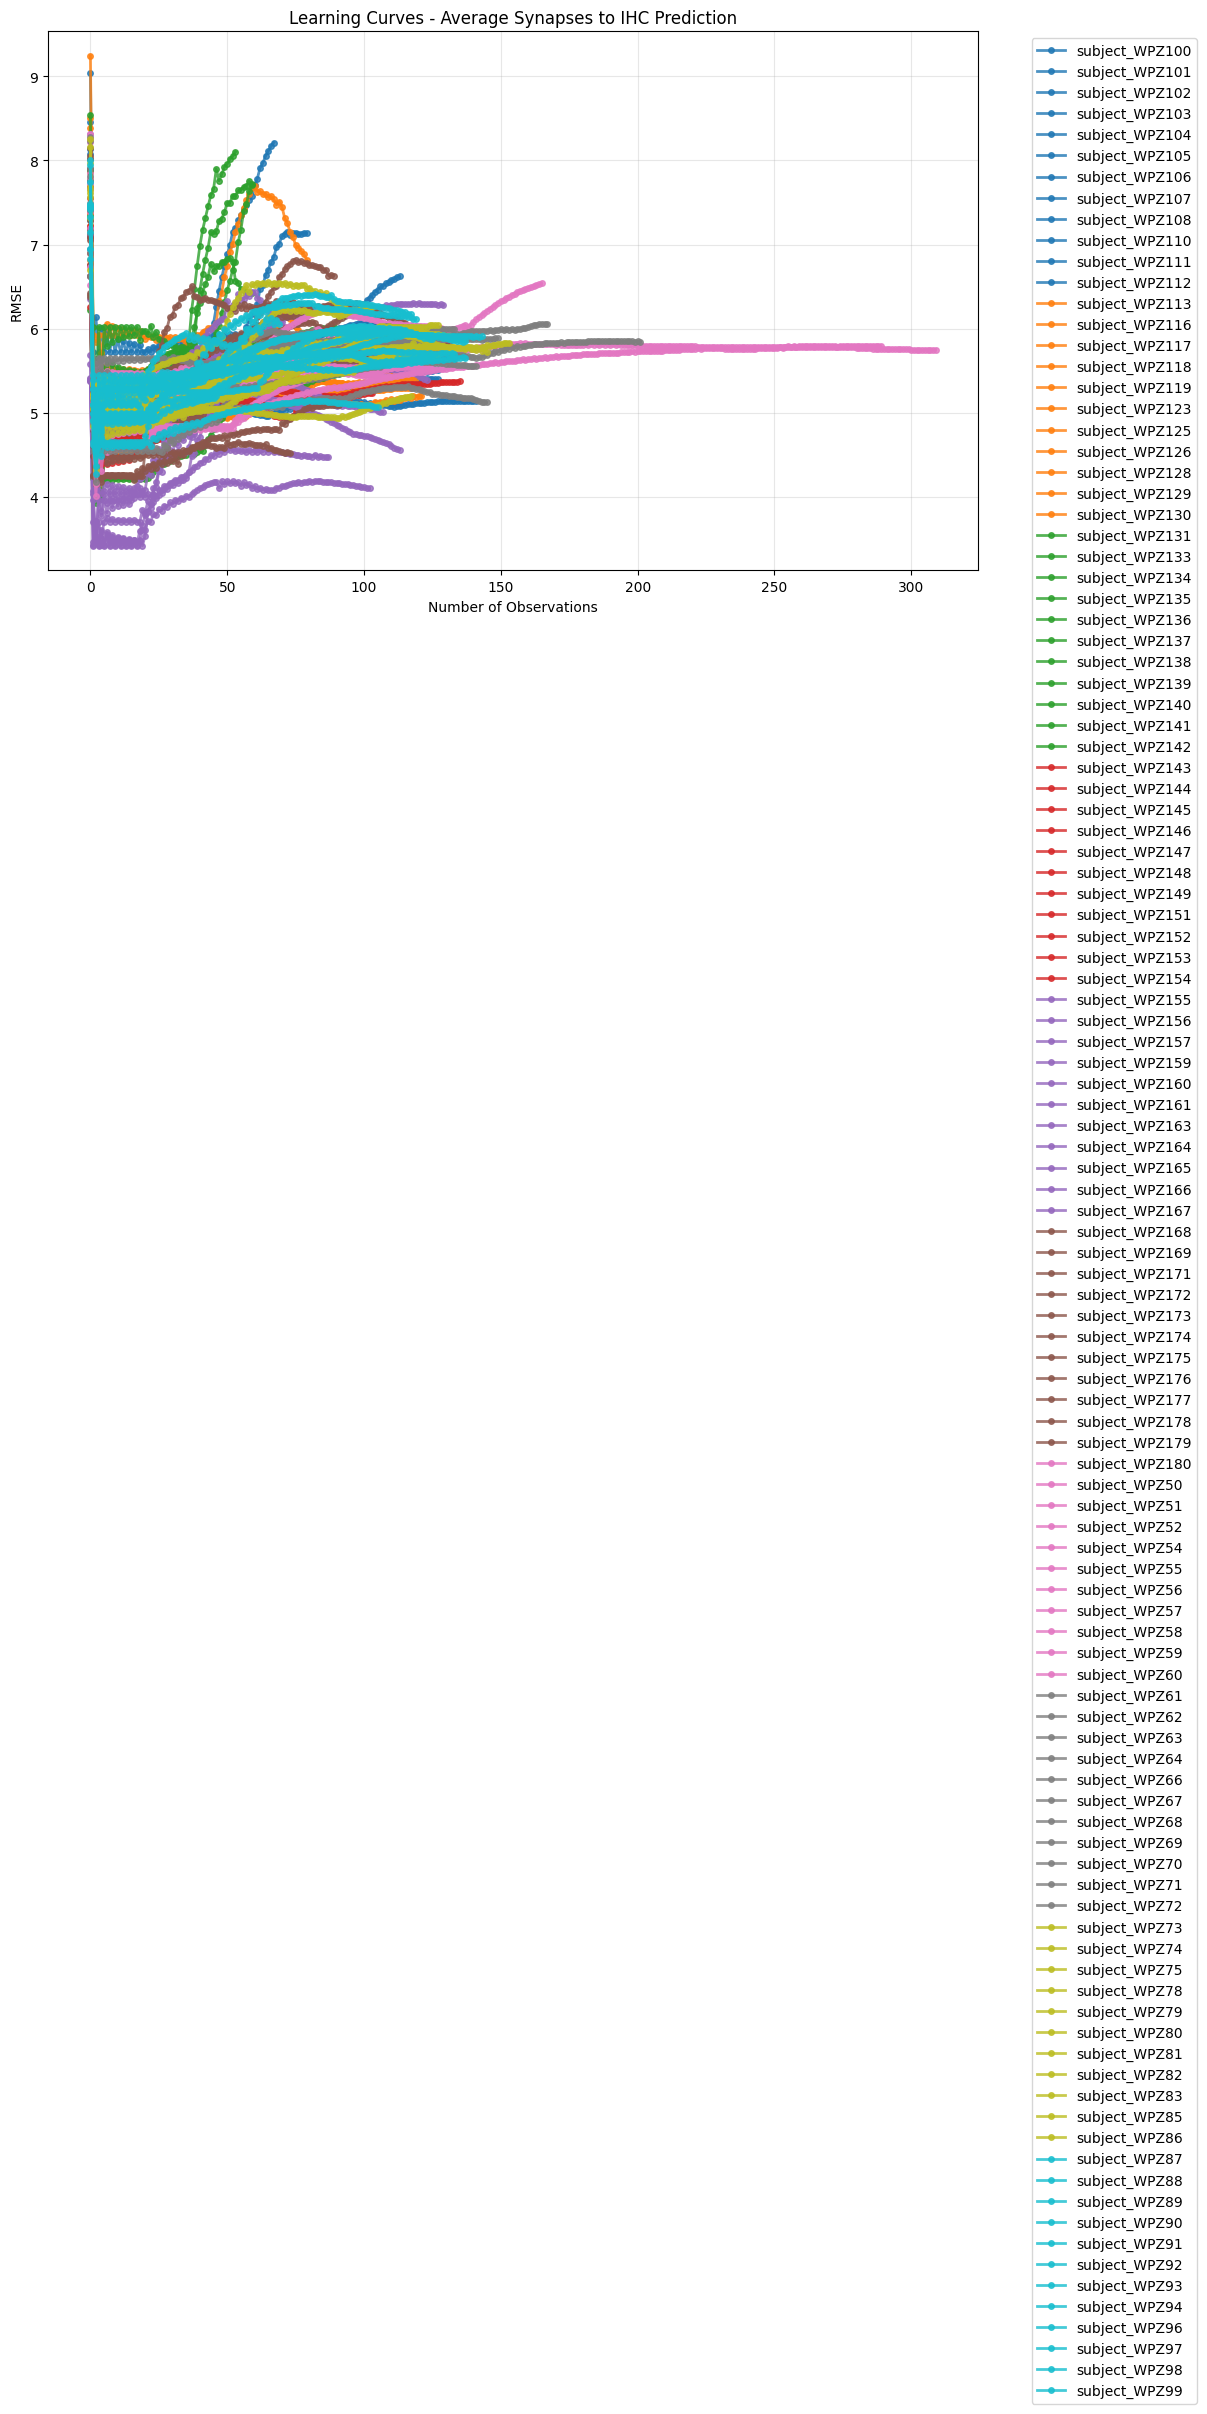

In [ ]:
plot_multiple_learning_curves(subject_profiles_test1.values(), profile_names=subject_profiles_test1.keys(), metric='y1', figsize=(12, 7));

In [ ]:
pred_y1 = subject_profiles_test1['subject_WPZ174'].predict_with_uncertainty_y1(x1=8000,x2=20,x3=0.09, x4='v1')[0]
# pred_y2 = subject_profiles_test1['subject_WPZ174'].predict_with_uncertainty_y2(x1=8000,x2=20,x3=0.09, x4='v1')[0]
print(f"Predicted Synapse-to-IHC Ratio: {float(pred_y1):.6f}")
# print(f"Predicted IHC Count: {float(pred_y2):.6f}")


Predicted Synapse-to-IHC Ratio: 15.693492


# Calculating Priors

In [ ]:
# for sub in np.unique(final_clean['Subject']):
#     if len(final_clean[final_clean['Subject']==sub]) <30:
#         print(sub)

In [ ]:
amp_df_full[amp_df_full['Subject']=='WPZ145'].head()

,Subject,Freq(Hz) (x1),Level(dB) (x2),Amplitude (x3)
0,WPZ145,45200.0,70.0,0.028765
1,WPZ145,45200.0,75.0,0.029873
2,WPZ145,45200.0,80.0,0.148699
3,WPZ145,8000.0,30.0,0.150156
4,WPZ145,8000.0,35.0,0.069440


In [ ]:
raw_synapse_counts[(raw_synapse_counts['Subject']=='WPZ145') & (raw_synapse_counts['Freq(Hz) (x1)']==45200.0)].head()

,Subject,Freq(Hz) (x1),Ribbons,Synapses,IHCs (y2),Synapses / IHC,Orphans / IHC,criterion Pixel Intensity,Synapses to IHC (y1),vx (x4)
1474,WPZ145,45200.0,87.0,77.0,8.8,8.750000,1.136364,40.0,8.750000,v1
1475,WPZ145,45200.0,109.0,98.0,9,10.888889,1.222222,40.0,10.888889,v2


In [ ]:
paired = amp_df_full.join(raw_synapse_counts.set_index(['Subject', 'Freq(Hz) (x1)']), on=['Subject', 'Freq(Hz) (x1)'])
slice = paired[paired['Subject']=='WPZ174'][['Subject', 'Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs (y2)']]
final = paired[['Subject', 'Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs (y2)']]
# final.info()

final_clean = final.dropna()
final_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12187 entries, 0 to 7330
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Subject               12187 non-null  object 
 1   Freq(Hz) (x1)         12187 non-null  float64
 2   Level(dB) (x2)        12187 non-null  float64
 3   Amplitude (x3)        12187 non-null  float64
 4   vx (x4)               12187 non-null  object 
 5   Synapses to IHC (y1)  12187 non-null  float64
 6   IHCs (y2)             12187 non-null  object 
dtypes: float64(4), object(3)
memory usage: 761.7+ KB


In [ ]:
NAs = final[final['vx (x4)'].isna()]
len(NAs['Subject'].unique())
NAs

,Subject,Freq(Hz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4),Synapses to IHC (y1),IHCs (y2)
346,WPZ120,22600.0,15.0,0.083917,NaN,NaN,NaN
347,WPZ120,22600.0,20.0,0.049704,NaN,NaN,NaN
348,WPZ120,22600.0,25.0,0.040928,NaN,NaN,NaN
349,WPZ120,22600.0,30.0,0.169892,NaN,NaN,NaN
350,WPZ120,22600.0,35.0,0.315170,NaN,NaN,NaN
...,...,...,...,...,...,...,...
7316,WPZ101,16000.0,40.0,0.581493,NaN,NaN,NaN
7317,WPZ101,16000.0,50.0,1.280829,NaN,NaN,NaN
7318,WPZ101,16000.0,60.0,1.369909,NaN,NaN,NaN
7319,WPZ101,16000.0,70.0,1.447205,NaN,NaN,NaN


In [ ]:
paired.head()

,Subject,Freq(Hz) (x1),Level(dB) (x2),Amplitude (x3),Ribbons,Synapses,IHCs (y2),Synapses / IHC,Orphans / IHC,criterion Pixel Intensity,Synapses to IHC (y1),vx (x4)
0,WPZ145,45200.0,70.0,0.028765,87.0,77.0,8.8,8.750000,1.136364,40.0,8.750000,v1
0,WPZ145,45200.0,70.0,0.028765,109.0,98.0,9,10.888889,1.222222,40.0,10.888889,v2
1,WPZ145,45200.0,75.0,0.029873,87.0,77.0,8.8,8.750000,1.136364,40.0,8.750000,v1
1,WPZ145,45200.0,75.0,0.029873,109.0,98.0,9,10.888889,1.222222,40.0,10.888889,v2
2,WPZ145,45200.0,80.0,0.148699,87.0,77.0,8.8,8.750000,1.136364,40.0,8.750000,v1


In [ ]:
priors_pairing = {}

for freq in np.unique(paired['Freq(Hz) (x1)']):
    for db in np.unique(paired['Level(dB) (x2)']):
        p1 = paired[(paired['Freq(Hz) (x1)']==freq) & (paired['Level(dB) (x2)']==db)]['Synapses to IHC (y1)'].mean()
        p2 = paired[(paired['Freq(Hz) (x1)']==freq) & (paired['Level(dB) (x2)']==db)]['IHCs (y2)'].mean()
        priors_pairing[(freq, db)] = (p1, p2)
        # print(type(freq), type(db), type(p1), type(p2))

In [ ]:
# len(priors_pairing)
len(np.unique(paired['Subject']))

121

In [ ]:
priors_pairing[(8000.0, 20.0)]

(np.float64(14.752804634992618), np.float64(9.393749999999997))

In [ ]:
# final_clean = final_clean.reset_index(drop=True, inplace=False)
# final_clean.drop(inplace=True, columns=['index', 'level_0'])
final_clean

final_clean[(final_clean['Subject']=='WPZ145') & (final_clean['Freq(Hz) (x1)'] == 45200.0) & (final_clean['Level(dB) (x2)'] == 70.0) & (final_clean['Amplitude (x3)'] == 0.028765) & (final_clean['vx (x4)']=='v1')]['IHCs (y2)']

0    8.8
Name: IHCs (y2), dtype: object

In [ ]:
final_clean[(final_clean['Subject']=='WPZ100') & (final_clean['Freq(Hz) (x1)'] == 45200.0) & (final_clean['Level(dB) (x2)'] == 60) & (final_clean['Amplitude (x3)'] == 0.631038) & (final_clean['vx (x4)']=='v2')]['IHCs (y2)']
# final_clean[(final_clean['Subject']=='WPZ100')]

6640    9
Name: IHCs (y2), dtype: object

In [ ]:
# subjects_profiles_retest['subject_WPZ100'].predict_with_uncertainty_y1(x1=45200.0, x2=60.0, x3=0.631038, x4='v2')

In [ ]:
# subjects_profiles_retest

In [ ]:
# if __name__ == "__main__":
#     subject_profiles_test1 = {}
    
#     for subject in np.unique(raw_synapse_counts['Subject']):
#         profile_key = f"subject_{subject}"
#         subject_profiles_test1[profile_key] = BayesianProfile_v2()

#         for freq in np.unique(raw_synapse_counts[raw_synapse_counts['Subject']==subject]['Freq(Hz) (x1)']):
#             subject_rep_y = raw_synapse_counts[(raw_synapse_counts['Subject']==subject) & (raw_synapse_counts['Freq(Hz) (x1)']==freq)]
#             subject_rep_x = amp_df_full[(amp_df_full['Subject']==subject) & (amp_df_full['Freq(Hz) (x1)']==freq)]
#             for n in range(len(subject_rep_x)):
#                 x1 = subject_rep_x['Freq(Hz) (x1)'].iloc[n]
#                 x2 = subject_rep_x['Level(dB) (x2)'].iloc[n]
#                 x3 = subject_rep_x['Amplitude (x3)'].iloc[n]
#                 # print("x1=",x1, "x2=",x2, "x3=",x3)
#                 for vx in np.unique(subject_rep_y[subject_rep_y['Subject']==subject]['vx (x4)']):
#                     x4 = vx
#                     y1 = subject_rep_y[(subject_rep_y['Subject']==subject) & (subject_rep_y['vx (x4)']==vx) & (subject_rep_y['Freq(Hz) (x1)'] == x1)]['Synapses to IHC (y1)']
#                     y1 = y1.values[0]
#                     y2 = subject_rep_y[(subject_rep_y['Subject']==subject) & (subject_rep_y['vx (x4)']==vx) & (subject_rep_y['Freq(Hz) (x1)'] == x1)]['IHCs (y2)']
#                     y2 = y2.values[0]
#                     # print("x4=", x4, "y1=", y1)
#                     subject_profiles_test1[profile_key].add_observation_y1(x1=x1, x2=x2, x3=x3, x4=x4, y1=y1)
#                     subject_profiles_test1[profile_key].add_observation_y2(x1=x1, x2=x2, x3=x3, x4=x4, y2=y2)

In [ ]:
# time_scale=10
# amp_per_freq = {'Subject': [], 'Freq(Hz) (x1)': [], 'Level(dB) (x2)': [], 'Amplitude (x3)':[]}
# start_path = '/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/WPZ Electrophysiology'
# for subject in os.listdir(start_path):
#     print("Subject:",subject)
#     for fq in os.listdir(os.path.join(start_path,subject)):
#         print(fq)
#         if fq.startswith('ABR') and fq.endswith('.tsv'):
#             path = os.path.join(start_path,subject,fq)
#             data_df = read_custom_tsv(path)
#             freqs = data_df['Freq(Hz)'].unique().tolist()
#             levels = data_df['Level(dB)'].unique().tolist()
#             for freq in freqs:
#                 for lvl in levels:
#                     # print("Frequency=",freq, "Level=", lvl)
#                     _, _, amp = peaks_troughs_amp_final(df=data_df, freq=freq, db=lvl, time_scale=time_scale)
#                     # print(f'Amplitude: {amp}\n')
#                     amp_per_freq['Subject'].append(subject)
#                     amp_per_freq['Freq(Hz) (x1)'].append(freq)
#                     amp_per_freq['Level(dB) (x2)'].append(lvl)
#                     amp_per_freq['Amplitude (x3)'].append(amp)
#         else:
#             pass
#         print(path)

# amp_df_full = pd.DataFrame(data=amp_per_freq)
# amp_df_full

# Train / Val / Test Split (Files)

In [ ]:
# data_bs = Path(base_image_directory)
# splitfolders.ratio(data_bs, output=('/Users/leahashebir/Downloads/Manor_Practicum/modeling/new_image_train.test.validate'), seed=1234, ratio=(0.7, 0.15, 0.15), group_prefix=None)

# train_path = "/Users/leahashebir/Downloads/Manor_Practicum/modeling/new_image_train.test.validate/train"
# val_path = "/Users/leahashebir/Downloads/Manor_Practicum/modeling/new_image_train.test.validate/val"

# img_height = 64 
# img_width = 64
# batch_size = 2  # How many images are in each batch for the training. Update to 20!!!
# channels = 3 #1 for grayscale, 3 for RGB. Default data_gen makes it grayscale!!
# input_shape = (batch_size, img_height, img_width, channels)

# data_gen = ImageDataGenerator(rescale=1./255)
# train_ds = data_gen.flow_from_directory(train_path, target_size=(img_height, img_width), class_mode='sparse', batch_size=batch_size, subset='training')
# val_ds = data_gen.flow_from_directory(val_path, target_size=(img_height, img_width), class_mode='sparse', batch_size=batch_size, shuffle=False)

# NN Model

In [ ]:
# import pytorch libraries
%matplotlib inline
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np4

from sklearn.metrics import r2_score

In [ ]:
# Setting up linear and loss functions

def lin(a,b,x): return a*x+b # Needs updating for my parameters?
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()
def mse_loss(a, b, x, y): return mse(lin(a,b,x), y)

def val_metric(model, valid_dl):
    model.eval()
    losses = []
    ys, y_pred = [], []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(valid_dl):
            y = y.unsqueeze(1)
            x1, x2, x3, x4_encoded = torch.split(x, [1,1,1,2], dim=1)

            x1 = x1.squeeze(1)
            x2 = x2.squeeze(1)
            x3 = x3.squeeze(1)

            y_hat = model(x1,x2,x3,x4_encoded)

            if torch.isnan(y_hat).any():
                print(f"NaN found in y_hat at batch {batch_idx}")
                print("Input values:", x1, x2, x3, x4_encoded)

            loss = F.mse_loss(y_hat, y)
            losses.append(loss.item())
            
            y_np = y.numpy()
            y_hat_np = y_hat.numpy()
            if np.isnan(y_np).any():
                print(f"NaN found in y_true at batch {batch_idx}")
            if np.isnan(y_hat_np).any():
                print(f"NaN found in y_pred at batch {batch_idx}")

            ys.extend(y_np)
            y_pred.extend(y_hat_np)
    
    return np.mean(losses), r2_score(ys, y_pred)

In [ ]:
class Ratio_LRNN(nn.Module):
    def __init__(self, hidden_layer=3):
        super(Ratio_LRNN, self).__init__()
        # self.lin = nn.Linear(1, 1)

        self.input_size = 5 # x1, x2, x3, x4 (2 dimensions w one-hot encoding) WITHOUT INTERACTIONS

        self.layers = nn.Sequential(
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(self.input_size, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, 1)

        )
        
    def forward(self, x1, x2, x3, x4):
        x4_encoded = torch.zeros(x4.size(0),2)
        x4_encoded[x4=='v1',0] = 1
        x4_encoded[x4=='v2',1] = 1

        X = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x4_encoded], dim=1)

        return self.layers(X)

    
class IHC_LRNN(nn.Module):
    def __init__(self, hidden_layer=32):
        super(IHC_LRNN, self).__init__()
        # self.lin = nn.Linear(1, 1)

        self.input_size = 5 # x1, x2, x3, x4, x5 WITHOUT INTERACTIONS

        self.layers = nn.Sequential(
            nn.BatchNorm1d(hidden_layer), # Standardizes inputs as we scale up/down our betas as to not overly penalize large values
            nn.Linear(self.input_size, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, 1)
        )
        
    def forward(self, x1, x2, x3, x4):
        x4_encoded = torch.zeros(x4.size(0),2)
        x4_encoded[x4=='v1',0] = 1
        x4_encoded[x4=='v2',1] = 1

        X = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x4_encoded], dim=1)

        return self.layers(X)

In [ ]:
model1 = Ratio_LRNN()
# model2 = IHC_LRNN()

learning_rate = 1
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=learning_rate)
# optimizer2 = torch.optim.AdamW(model2.parameters(), lr=learning_rate)
torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1.0)

tensor(0.)

# Trying out NN with Train/Test Split

In [ ]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [ ]:
final # Each combination of freq/level/amp/vx/syn:ihc ratio/IHC count

,Subject,Freq(Hz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4),Synapses to IHC (y1),IHCs (y2)
0,WPZ145,45200.0,70.0,0.028765,v1,8.750000,8.8
0,WPZ145,45200.0,70.0,0.028765,v2,10.888889,9
1,WPZ145,45200.0,75.0,0.029873,v1,8.750000,8.8
1,WPZ145,45200.0,75.0,0.029873,v2,10.888889,9
2,WPZ145,45200.0,80.0,0.148699,v1,8.750000,8.8
...,...,...,...,...,...,...,...
7328,WPZ101,32000.0,60.0,1.272086,v2,15.463918,9.7
7329,WPZ101,32000.0,70.0,1.057558,v1,16.923077,9.1
7329,WPZ101,32000.0,70.0,1.057558,v2,15.463918,9.7
7330,WPZ101,32000.0,80.0,1.017517,v1,16.923077,9.1


In [ ]:
X_num = final_clean[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean['vx (x4)']
y1 = final_clean['Synapses to IHC (y1)']
# y2 = final_clean['IHCs (y2)']

In [ ]:
X_num_train1, X_num_test1, X_cat_train1, X_cat_test1, y1_train, y1_test = train_test_split(
    X_num, X_cat, y1,
    test_size=0.2,
    random_state=42
)

X_cat_train_encoded = pd.get_dummies(X_cat_train1)
X_cat_test_encoded = pd.get_dummies(X_cat_test1)

X_train = pd.concat([X_num_train1, X_cat_train_encoded], axis=1)
X_test = pd.concat([X_num_test1, X_cat_test_encoded], axis=1)

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y1_train = y1_train.astype('float64')
y1_test = y1_test.astype('float64')

X_train_tensor1 = torch.FloatTensor(X_train.values)
X_test_tensor1 = torch.FloatTensor(X_test.values)
y1_train_tensor = torch.FloatTensor(y1_train.values)
y1_test_tensor = torch.FloatTensor(y1_test.values)


In [ ]:
def train_loop(model, train_dl, valid_dl, optimizer, epochs):
    for i in range(epochs):
        model.train()
        batch_losses = []  # Reset losses for each epoch
        for batch in train_dl:
            x, y = batch  # x is [32, 5], y is [32]
            y = y.unsqueeze(1)  # [32, 1] to match y_hat
            x1,x2,x3,x4_encoded = torch.split(x, [1,1,1,2], dim=1)
            x1 = x1.squeeze()
            x2 = x2.squeeze()
            x3 = x3.squeeze()
            y_hat = model.forward(x1,x2,x3,x4_encoded)

            if torch.isnan(y_hat).any():
                print("NaN detected in predictions")
                continue

            loss = F.mse_loss(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Keeps the gradient descent from going too quickly, which can lead to NAs!
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        train_loss = np.mean(batch_losses)
        valid_loss, valid_r2 = val_metric(model, valid_dl)
        print(f"Epoch {i+1}: train loss {train_loss:.3f} valid loss {valid_loss:.3f} R^2 {valid_r2:.3f}")

In [ ]:
train_dataset1 = TensorDataset(X_train_tensor1, y1_train_tensor)
train_dl = DataLoader(train_dataset1, batch_size=32, shuffle=True)

valid_dataset1 = TensorDataset(X_test_tensor1, y1_test_tensor)
valid_dl = DataLoader(valid_dataset1, batch_size=32, shuffle=False)

train_loop(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
# print(f'Length of train tensor: {len(train_dl)}')
# for batch in train_dl:
#     x, y = batch
#     print("Shape of each feature batch:", x.shape)
#     print("Shape of each target batch:", y.shape)
#     break

RuntimeError: running_mean should contain 5 elements not 3

# Train/Test Split - Bayesian Model

In [ ]:
final_clean

,Subject,Freq(Hz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4),Synapses to IHC (y1),IHCs (y2)
0,WPZ145,45200.0,70.0,0.028765,v1,8.750000,8.8
0,WPZ145,45200.0,70.0,0.028765,v2,10.888889,9
1,WPZ145,45200.0,75.0,0.029873,v1,8.750000,8.8
1,WPZ145,45200.0,75.0,0.029873,v2,10.888889,9
2,WPZ145,45200.0,80.0,0.148699,v1,8.750000,8.8
...,...,...,...,...,...,...,...
7328,WPZ101,32000.0,60.0,1.272086,v2,15.463918,9.7
7329,WPZ101,32000.0,70.0,1.057558,v1,16.923077,9.1
7329,WPZ101,32000.0,70.0,1.057558,v2,15.463918,9.7
7330,WPZ101,32000.0,80.0,1.017517,v1,16.923077,9.1


In [ ]:
subjects_profiles_retest = {}

for subject in np.unique(raw_synapse_counts['Subject']):
    profile_key = f"subject_{subject}"
    subjects_profiles_retest[profile_key] = BayesianProfile_v3()

    for freq in np.unique(final_clean[final_clean['Subject']==subject]['Freq(Hz) (x1)']):
        for db in np.unique(final_clean[final_clean['Subject']==subject]['Level(dB) (x2)']):
            for amp in np.unique(final_clean[final_clean['Subject']==subject]['Amplitude (x3)']):
                for vx in np.unique(final_clean[final_clean['Subject']==subject]['vx (x4)']):
                    # x1 = freq
                    # x2 = db
                    # x3 = amp
                    # x4 = vx
                    # print(type(freq), type(db), type(amp), type(vx))
                    y1 = final_clean[(final_clean['Subject']==subject) & (final_clean['Freq(Hz) (x1)'] == freq) & (final_clean['Level(dB) (x2)'] == db) & (final_clean['Amplitude (x3)'] == amp) & (final_clean['vx (x4)']==vx)]['Synapses to IHC (y1)']
                    y2 = final_clean[(final_clean['Subject']==subject) & (final_clean['Freq(Hz) (x1)'] == freq) & (final_clean['Level(dB) (x2)'] == db) & (final_clean['Amplitude (x3)'] == amp) & (final_clean['vx (x4)']==vx)]['IHCs (y2)']
                    # print(y1,y2)
                    if len(y1) == 0:
                        continue
                    subjects_profiles_retest[profile_key].add_observation_y1(x1=freq, x2=db, x3=amp, x4=vx, y1=y1)
                    subjects_profiles_retest[profile_key].add_observation_y2(x1=freq, x2=db, x3=amp, x4=vx, y2=y2)
                    # print(f'{subject} - {freq} - {db} - {amp} - {vx} - {y1} - {y2} completed')


In [ ]:
from sklearn.model_selection import train_test_split

X_num = final_clean[['Subject','Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean['vx (x4)']
X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean['Synapses to IHC (y1)']
y2 = final_clean['IHCs (y2)']

X_train1, X_test1, y1_train, y1_test = train_test_split(
    X_combined, y1,
    test_size=0.2,
    random_state=42
)

# X_num_train2, X_num_test2, X_cat_train2, X_cat_test2, y2_train, y2_test = train_test_split(
#     X_num, X_cat, y2,
#     test_size=0.2,
#     random_state=42
# )

In [ ]:
train_subjects = set(X_train1['Subject'])
test_subjects = set(X_test1['Subject'])

overlap = train_subjects.intersection(test_subjects)

len(train_subjects), len(test_subjects), len(overlap)

(105, 105, 105)

In [ ]:
y1_train.loc[6581]

np.float64(15.74468085106383)

In [ ]:
X_train1.loc[6582]

,Subject,Freq(Hz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4)
6582,WPZ100,8000.0,20.0,0.165109,0
6582,WPZ100,8000.0,20.0,0.165109,1


In [ ]:
# freq=45200.0, db=80.0, amp=0.544555, vx=1, idx=Index([5784], dtype='int64'), y1=16.555555555555557

final_clean[(final_clean['Subject']=='WPZ100') & (final_clean['Freq(Hz) (x1)'] == 8000.0) & ((final_clean['Level(dB) (x2)'] == 60.0) | (final_clean['Level(dB) (x2)'] == 70.0) | (final_clean['Level(dB) (x2)'] == 25.0))]

# subject=WPZ100, freq=8000.0, db=60.0, amp=0.8897889999999999, vx=1, idx=Index([6588], dtype='int64'), y1=15.74468085106383 - loaded
# subject=WPZ100, freq=8000.0, db=70.0, amp=0.9940739999999999, vx=0, idx=Index([6589], dtype='int64'), y1=15.74468085106383 - loaded

,Subject,Freq(Hz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4),Synapses to IHC (y1),IHCs (y2)
6583,WPZ100,8000.0,25.0,0.063769,v1,15.744681,9.4
6583,WPZ100,8000.0,25.0,0.063769,v2,16.039604,10.1
6588,WPZ100,8000.0,60.0,0.889789,v1,15.744681,9.4
6588,WPZ100,8000.0,60.0,0.889789,v2,16.039604,10.1
6589,WPZ100,8000.0,70.0,0.994074,v1,15.744681,9.4
6589,WPZ100,8000.0,70.0,0.994074,v2,16.039604,10.1


In [ ]:
subjects_profiles_TTsplit = {}

for subject in np.unique(X_train1['Subject']):
    profile_key = f"subject_{subject}"
    subjects_profiles_TTsplit[profile_key] = BayesianProfile_v3()

    for freq in np.unique(X_train1[X_train1['Subject']==subject]['Freq(Hz) (x1)']):
        for db in np.unique(X_train1[X_train1['Subject']==subject]['Level(dB) (x2)']):
            for amp in np.unique(X_train1[X_train1['Subject']==subject]['Amplitude (x3)']):
                for vx in np.unique(X_train1[X_train1['Subject']==subject]['vx (x4)']):
                    record_X = X_train1[(X_train1['Subject']==subject) & (X_train1['Freq(Hz) (x1)'] == freq) & (X_train1['Level(dB) (x2)'] == db) & (X_train1['Amplitude (x3)'] == amp) & (X_train1['vx (x4)']==vx)]
                    idx = record_X.index
                    
                    if len(y1_train.loc[idx]) == 2:
                        if vx == 0:
                            y1_0 = float(y1_train.loc[idx].values[0])
                            subjects_profiles_TTsplit[profile_key].add_observation_y1(x1=freq, x2=db, x3=amp, x4=vx, y1=y1_0)
                            print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx}, y1={y1_0} - loaded")
                        elif vx == 1:
                            y1_1 = float(y1_train.loc[idx].values[1])
                            subjects_profiles_TTsplit[profile_key].add_observation_y1(x1=freq, x2=db, x3=amp, x4=vx, y1=y1_1)
                            print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx}, y1={y1_1} - loaded")


                    elif len(y1_train.loc[idx]) == 1:
                        y1 = y1_train.loc[idx].values[0]
                        subjects_profiles_TTsplit[profile_key].add_observation_y1(x1=freq, x2=db, x3=amp, x4=vx, y1=y1)
                        print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx}, y1={y1} - loaded")

                        # print(f"freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx}")



subject=WPZ100, freq=8000.0, db=15.0, amp=0.07549, vx=0, idx=Index([6581], dtype='int64'), y1=15.74468085106383 - loaded
subject=WPZ100, freq=8000.0, db=20.0, amp=0.165109, vx=0, idx=Index([6582], dtype='int64'), y1=15.74468085106383 - loaded
subject=WPZ100, freq=8000.0, db=20.0, amp=0.165109, vx=1, idx=Index([6582], dtype='int64'), y1=16.03960396039604 - loaded
subject=WPZ100, freq=8000.0, db=25.0, amp=0.063769, vx=0, idx=Index([6583], dtype='int64'), y1=15.74468085106383 - loaded
subject=WPZ100, freq=8000.0, db=25.0, amp=0.063769, vx=1, idx=Index([6583], dtype='int64'), y1=16.03960396039604 - loaded
subject=WPZ100, freq=8000.0, db=30.0, amp=0.133842, vx=1, idx=Index([6584], dtype='int64'), y1=16.03960396039604 - loaded
subject=WPZ100, freq=8000.0, db=35.0, amp=0.292298, vx=0, idx=Index([6585], dtype='int64'), y1=15.74468085106383 - loaded
subject=WPZ100, freq=8000.0, db=35.0, amp=0.292298, vx=1, idx=Index([6585], dtype='int64'), y1=16.03960396039604 - loaded
subject=WPZ100, freq=8000

In [ ]:
subjects = []
RMSES = []
freqs = []
dbs = []
amps = []
vxs = []
ys = []
y_preds = []

for subject in np.unique(X_test1['Subject']):
    profile_key = f"subject_{subject}"
    subject_rmses = []
    for freq in np.unique(X_test1[X_test1['Subject']==subject]['Freq(Hz) (x1)']):
        for db in np.unique(X_test1[X_test1['Subject']==subject]['Level(dB) (x2)']):
            for amp in np.unique(X_test1[X_test1['Subject']==subject]['Amplitude (x3)']):
                for vx in np.unique(X_test1[X_test1['Subject']==subject]['vx (x4)']):
                    record_X = X_test1[(X_test1['Subject']==subject) & (X_test1['Freq(Hz) (x1)'] == freq) & (X_test1['Level(dB) (x2)'] == db) & (X_test1['Amplitude (x3)'] == amp) & (X_test1['vx (x4)']==vx)]
                    idx = record_X.index
                    
                    if len(y1_test.loc[idx]) == 2:
                        if vx == 0:
                            y1_v1 = float(y1_test.loc[idx].values[0])
                            y1_v1_pred = subjects_profiles_TTsplit[profile_key].predict_y1(x1=freq, x2=db, x3=amp, x4=vx)
                            RMSE = np.sqrt(np.mean((y1_v1-y1_v1_pred)**2))
                            subjects.append(subject)
                            freqs.append(freq)
                            dbs.append(db)
                            amps.append(amp)
                            vxs.append(vx)
                            ys.append(y1_v1)
                            y_preds.append(y1_v1_pred)
                            RMSES.append(RMSE)
                            # print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx} - predicted y1={y1_v1_pred}")

                        elif vx == 1:
                            y1_v2 = float(y1_test.loc[idx].values[1])
                            y1_v2_pred = subjects_profiles_TTsplit[profile_key].predict_y1(x1=freq, x2=db, x3=amp, x4=vx)
                            RMSE = np.sqrt(np.mean((y1_v2-y1_v2_pred)**2))
                            subjects.append(subject)
                            freqs.append(freq)
                            dbs.append(db)
                            amps.append(amp)
                            vxs.append(vx)
                            ys.append(y1_v2)
                            y_preds.append(y1_v2_pred)
                            RMSES.append(RMSE)
                            # print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx} - predicted y1={y1_v2_pred}")

                    elif len(y1_test.loc[idx]) == 1:
                        y1 = float(y1_test.loc[idx].values[0])
                        y1_pred = subjects_profiles_TTsplit[profile_key].predict_y1(x1=freq, x2=db, x3=amp, x4=vx)
                        RMSE = np.sqrt(np.mean((y1-y1_pred)**2))
                        subjects.append(subject)
                        freqs.append(freq)
                        dbs.append(db)
                        amps.append(amp)
                        vxs.append(vx)
                        ys.append(y1)
                        y_preds.append(y1_pred)
                        RMSES.append(RMSE)
                        # print(f"subject={subject}, freq={freq}, db={db}, amp={amp}, vx={vx}, idx={idx} - predicted y1={y1_pred}")

test_results = {
    'Subject': subjects, 
    'FreqHz (x1)': freqs, 
    'LeveldB (x2)': dbs, 
    'Amplitude (x3)': amps, 
    'vx (x4)': vxs,
    'Synapses to IHC (y1)' : ys,
    'y1 Predictions' : y_preds,
    'RMSEs': RMSES
}

results_df = pd.DataFrame(data=test_results)


# Visualizations on Bayesian Model

In [ ]:
results_df.head()

,Subject,FreqHz (x1),LeveldB (x2),Amplitude (x3),vx (x4),Synapses to IHC (y1),y1 Predictions,RMSEs
0,WPZ100,8000.0,15.0,0.075490,1,18.200000,[18.225931088944886],0.048466
1,WPZ100,8000.0,30.0,0.133842,0,18.200000,[18.225931088944886],0.761508
2,WPZ100,8000.0,50.0,0.657141,0,16.039604,[16.639695729073832],0.600092
3,WPZ100,8000.0,50.0,0.657141,1,16.039604,[16.639695729073832],0.895015
4,WPZ100,8000.0,70.0,0.994074,1,16.039604,[16.639695729073832],0.629557


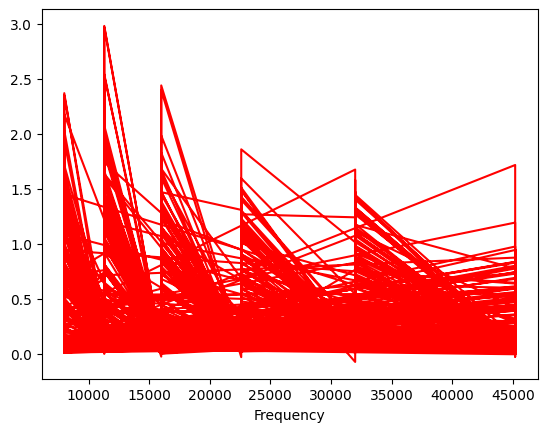

In [ ]:
# plt.scatter(results_df['Amplitude (x3)'], results_df['Synapses to IHC (y1)'], color = 'blue')
plt.plot(results_df['FreqHz (x1)'], results_df['Amplitude (x3)'], color = 'red')
plt.xlabel('Frequency')
plt.show()

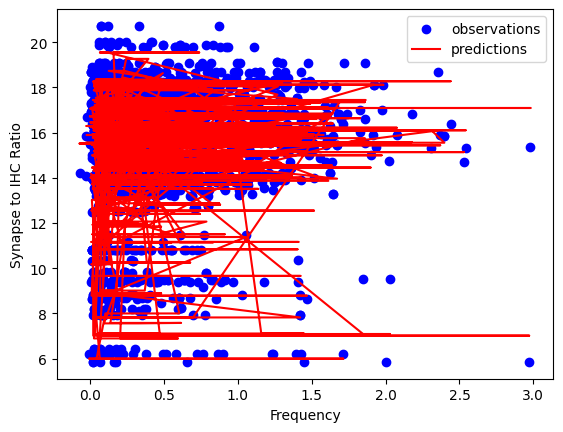

In [ ]:
# for freq in np.unique(results_df['FreqHz (x1)']):
#     mask = results_df[results_df['FreqHz (x1)'] == freq]
plt.scatter(results_df['Amplitude (x3)'], results_df['Synapses to IHC (y1)'], color = 'blue', label = "observations")
plt.plot(results_df['Amplitude (x3)'], results_df['y1 Predictions'], color = 'red', label = "predictions")
plt.legend()
plt.xlabel('Frequency')
plt.ylabel("Synapse to IHC Ratio")
plt.title("")
plt.show()

In [ ]:
average_by_subject = results_df.groupby('Subject')['RMSEs'].mean()
average_by_subject = pd.DataFrame(average_by_subject).reset_index

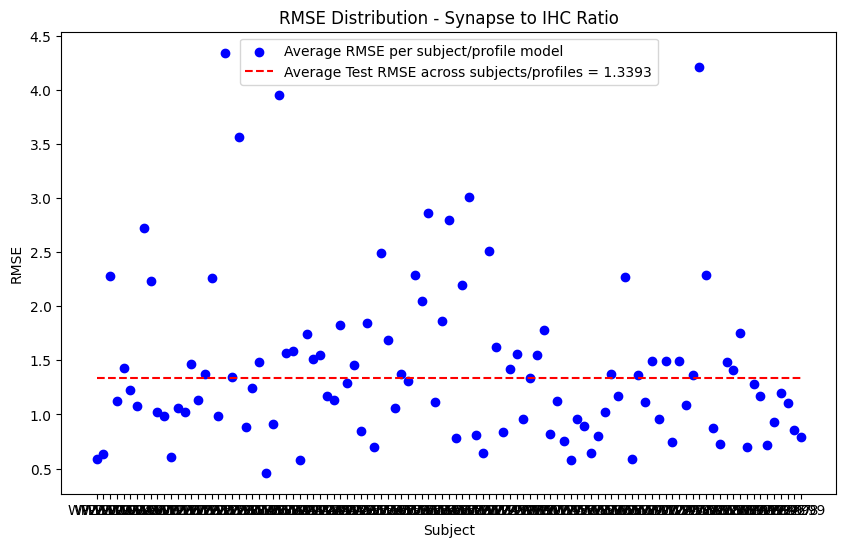

In [ ]:
plt.figure(figsize=(10, 6))
# plt.bar(results_df['Subject'], results_df['RMSEs'])
plt.scatter(average_by_subject['Subject'], average_by_subject['RMSEs'], color='blue', label='Average RMSE per subject/profile model')
plt.title('RMSE Distribution - Synapse to IHC Ratio')
plt.hlines(y=results_df['RMSEs'].mean(), 
          xmin=min(results_df['Subject']), 
          xmax=max(results_df['Subject']), 
          colors='red', 
          linestyles='dashed',
          label= f'Average Test RMSE across subjects/profiles = {results_df["RMSEs"].mean():.4f}')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Subject')
plt.show()

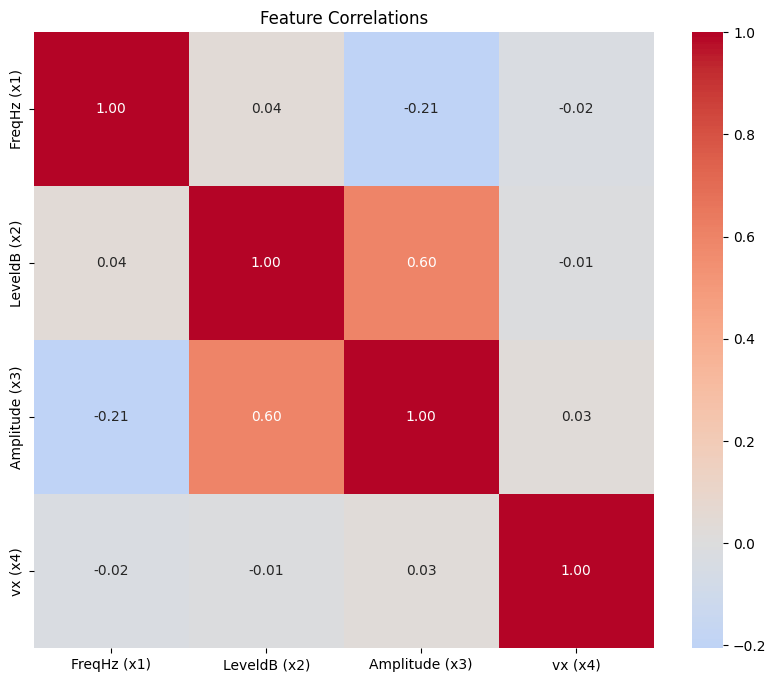

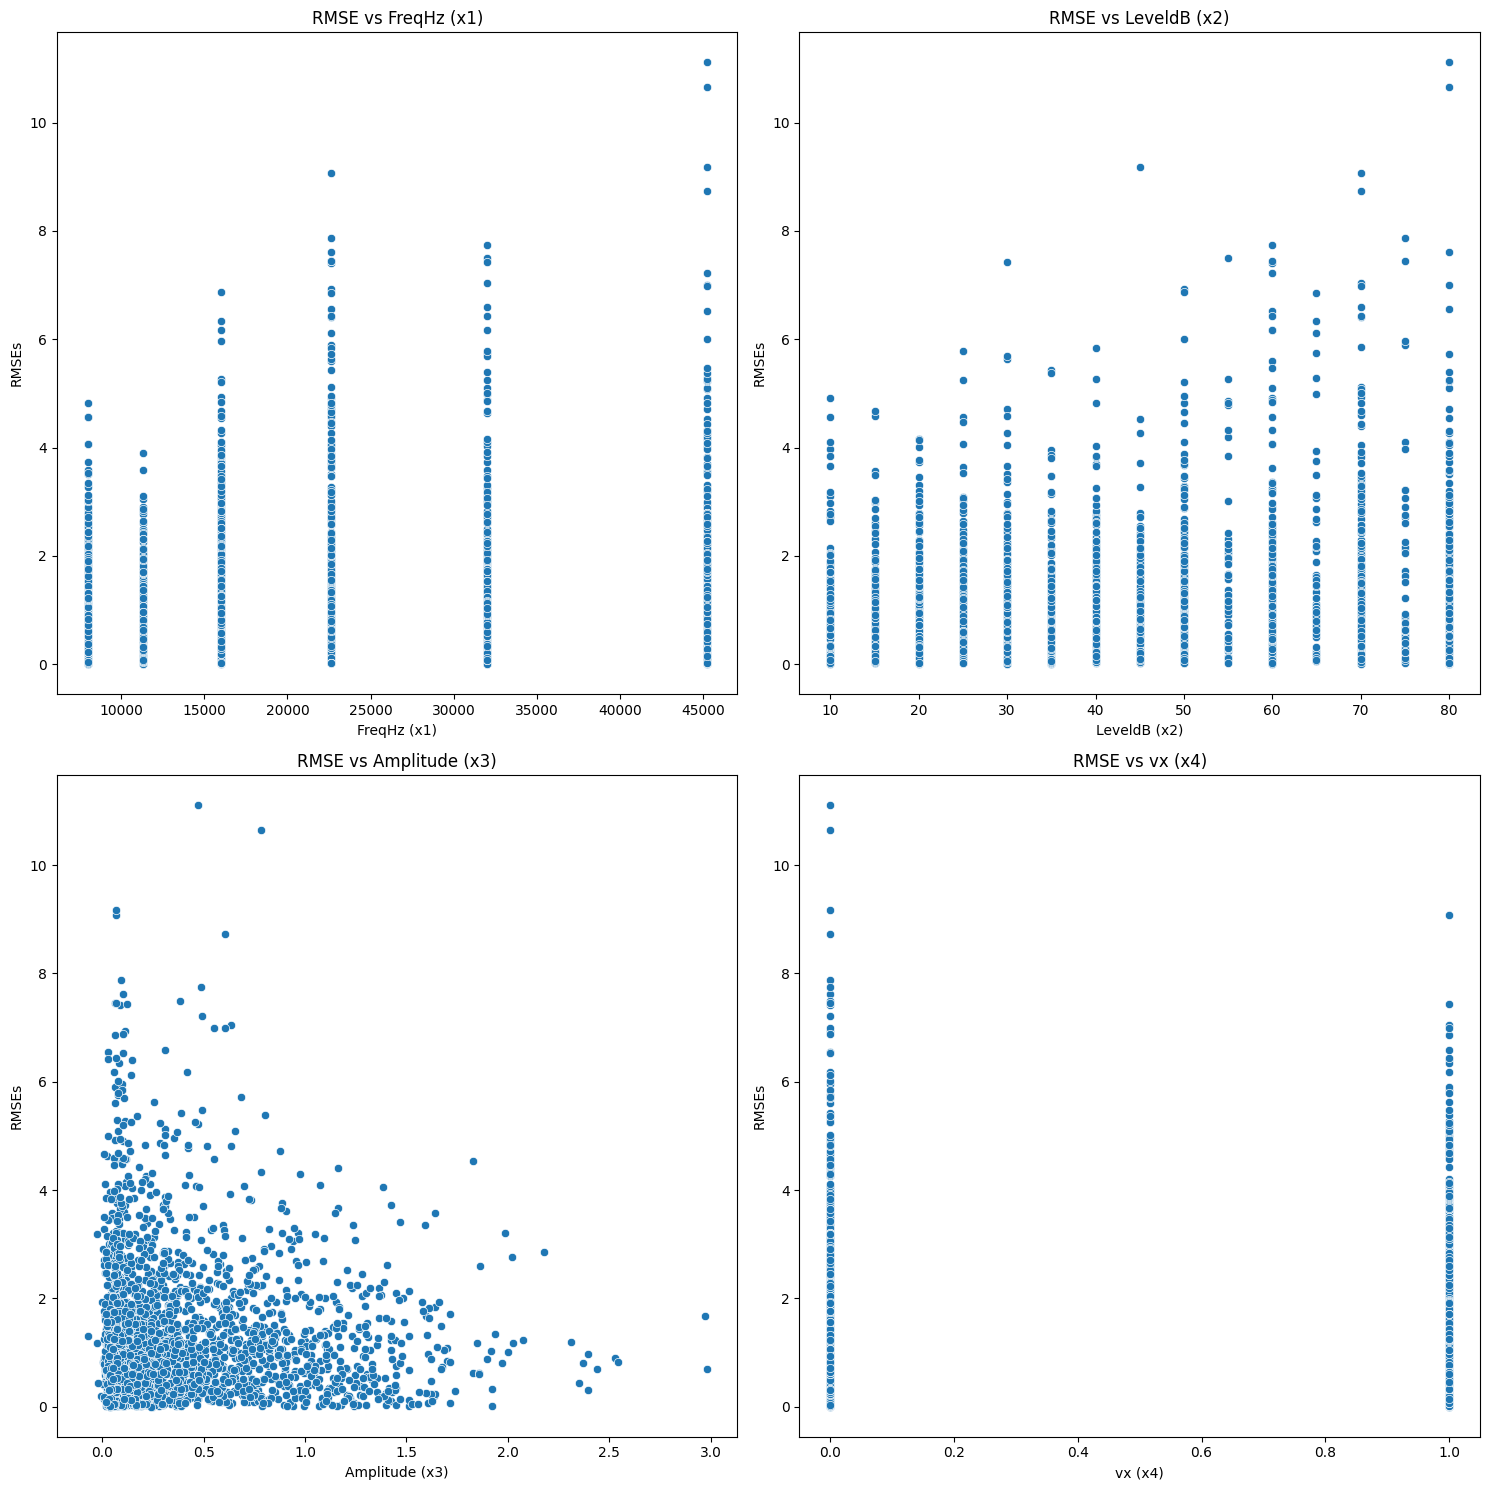

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create correlation matrix
corr_matrix = results_df[['FreqHz (x1)', 'LeveldB (x2)', 'Amplitude (x3)', 'vx (x4)']].corr()

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Red for positive, blue for negative correlations
            center=0,  # Center the colormap at 0
            fmt='.2f')  # Format correlation values to 2 decimal places
plt.title('Feature Correlations')
plt.show()

# For individual scatter plots
features = ['FreqHz (x1)', 'LeveldB (x2)', 'Amplitude (x3)', 'vx (x4)']
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.ravel()

for idx, feature in enumerate(features):
    sns.scatterplot(data=results_df, 
                   x=feature, 
                   y='RMSEs', 
                   ax=axes[idx])
    axes[idx].set_title(f'RMSE vs {feature}')

plt.tight_layout()
plt.show()

# Random Forest

## No vx or normalization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.model_selection import train_test_split

X_num = final_clean[['Subject','Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
# X_cat = final_clean['vx (x4)']
# X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
# X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean['Synapses to IHC (y1)']
# y2 = final_clean['IHCs (y2)']

X_train1, X_test1, y1_train, y1_test = train_test_split(
    X_combined, y1,
    test_size=0.2,
    random_state=42
)

NameError: name 'final_clean' is not defined

In [ ]:
preprocessor = ColumnTransformer([
    ('num_scaler', StandardScaler(), X_num.columns),  # Standardize numerical features
    ('cat_encoder', OneHotEncoder(drop='first'), ['experiment'])  # One-hot encode experiment type
])

# Create Random Forest Pipeline
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
rf_pipeline.fit(X_train1, y1_train)

# Extract trained Random Forest model from the pipeline
rf_model = rf_pipeline.named_steps['rf']

In [ ]:
# Get feature names after preprocessing
num_features = X_num.columns.tolist()
cat_features = ['experiment_V2']  # Because OneHotEncoder(drop='first') removes 'V1', only 'V2' remains

feature_names = num_features + cat_features

# Get feature importance
feature_importance = rf_model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

## With vx and without normalization

In [ ]:
from sklearn.model_selection import train_test_split

X_num = final_clean[['Subject','Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean['vx (x4)']
X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean['Synapses to IHC (y1)']
# y2 = final_clean['IHCs (y2)']

X_train1, X_test1, y1_train, y1_test = train_test_split(
    X_combined, y1,
    test_size=0.2,
    random_state=42
)

## With vx and normalization